In [68]:
import numpy as np
import matplotlib.pyplot as plt

In [69]:
class Vehicle:
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_lane, lane_changing_prob):
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_lane = current_lane #also known as the y position of the left side of the vehicle
        self.lane_changing_prob = lane_changing_prob
        #self.passenger_capacity = passenger_capacity
        #self.occupied_seats = occupied_seats
        #self.unoccupied_seats = unoccupied_seats
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def lane_changing(self, gap_distance):
        """attempts to change lanes based on vehicle type and lane availability"""
        #Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide, with 1 cell wide passenger holding area beside row 0)
        #we assume that each half lane is an array, imagine a vertical stack of arrays, indexing is from top to bottom (0-4). Right side is the bottom.
        new_lane = self.current_lane
        if self.speed > gap_distance:
            if self.current_lane == 0: #There are specific cases wherein changing to the right or left lane is possible/legal
                new_lane = self.current_lane + 2
            elif self.current_lane == 2: #This is slightly hardcoded. 
                new_lane = self.current_lane - 2
        #Check for space on the lane of interest
        if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_lane:new_lane + self.width].sum() == 0:
            self.current_lane = new_lane

    def decelerate(self, gap_distance):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        if self.speed > gap_distance:
            self.speed = gap_distance

    def randomize(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1

    def move(self):
        """implements movement"""
        self.x_position = (self.x_position + self.speed) % self.road_designation.road_length

In [70]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width #dictates the number of lanes. One lane is 2 cells wide.
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width)) #note that this road is vertical when printed/visualized

In [71]:
class IntraRoadSimulator:
    def __init__(self, road):
        """This method stores the necessary information to move the vehicles in a given space(road)"""
        self.road = road #this class demands an input road
        self.vehicles = [] #collection of vehicles on the road
        self.occupancy_history = [] #initializes an empty array to store the road configuration for visualization purposes

    def update_occupancy(self):
        """This method updates road occupancy. Occupied is 1, while empty is 0"""
        self.road.road_occupancy.fill(0) #clears the occupancy information from the previous timestep. One road occupancy array is good for one timestep.
        for vehicle in self.vehicles: #updates occupancy for all vehicles
            if vehicle.x_position < self.road.road_length - 1: #check if the position of the vehicle does not exceed road bounds
                x_start = vehicle.x_position #location of the rear bumper
                x_end = (vehicle.x_position + vehicle.length) % self.road.road_length #location of the front bumper
                y_start = vehicle.current_lane #right side of the vehicle
                y_end = min(vehicle.current_lane + vehicle.width, self.road.road_width)#right side of the vehicle
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1 #Declares the occupied cells. Note that x_end and y_end are not inclusive of the range.

                if x_start < x_end:
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
                else: #Handle wrapping around in toroidal boundary condition
                    self.road.road_occupancy[x_start:, y_start:y_end] = 1
                    self.road.road_occupancy[:x_end, y_start:y_end] = 1
        
        self.occupancy_history.append(self.road.road_occupancy.copy()) #stores the occupancy per iteration

    def produce_vehicles(self, density, truck_fraction):
        """Generate vehicles and place it on the road"""
        A, B = 7 * 2, 3 * 2 #areas of truck and jeep, respectively
        L, W = self.road.road_length, self.road.road_width
        N = int(density * L * W *(truck_fraction / A + (1 - truck_fraction) / B)) #number of vehicles 

        for _ in range(N):
            vehicle_type = 'truck' if np.random.rand() < truck_fraction else 'jeep'
            length = 7 if vehicle_type == 'truck' else 3
            width = 2 #all vehicles occupy 2 cells across the width
            x_position = np.random.randint(0, self.road.road_length)
            current_lane = np.random.choice([0, 2])
            speed = np.random.randint(1, self.road.speed_limit + 1)
            lane_changing_prob = 0.5 #can be adjusted
            
            #Place vehicle if there's enough space
            road_portion_to_be_placed = self.road.road_occupancy[x_position:x_position + length, current_lane:current_lane + width]
            if np.sum(road_portion_to_be_placed) == 0:
                new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_lane, lane_changing_prob)
                self.vehicles.append(new_vehicle)
                self.road.road_occupancy[x_position:x_position + length, current_lane:current_lane + width] = 1

    def gap_distance(self, vehicle, vehicle_lane_to_be_checked): #This is being revised (8/1/2024)
        current_x_position = vehicle.x_position
        max_distance = min(vehicle.speed, self.road.road_length - current_x_position - vehicle.length) # By default, headway is the speed of the vehicle

        lane_row_1 = vehicle_lane_to_be_checked #The first row of the lane
        lane_row_2 = lane_row_1 +1 #The second row of the lane

        #Initialize gap distances for both rows
        gap_distance_row_1 = max_distance
        gap_distance_row_2 = max_distance

        #Check the gap distance for the first row of the lane
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle.current_lane] == 1:
                gap_distance_row_1 =  distance - 1
                break

        #Check the gap distance for the second row of the lane
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length or self.road.road_occupancy[next_x_position, vehicle.current_lane] == 1:
                gap_distance_row_2 = distance - 1
                break

        #Return the minimum gap dostance between the two rows in the lane
        return min(gap_distance_row_1, gap_distance_row_2)
        
    def simulation_step(self, density, truck_fraction):
        self.produce_vehicles(density, truck_fraction)

        for vehicle in self.vehicles:
            #determine gap distance conditions before proceeding
            gap_distance_of_own_lane = self.gap_distance(vehicle, vehicle.current_lane)
            
            vehicle.accelerate()
            
            if vehicle.speed > gap_distance_of_own_lane:
                other_lane = 2 if vehicle.current_lane == 0 else 0
                gap_distance_of_other_lane = self.gap_distance(vehicle, other_lane)

                if gap_distance_of_other_lane > gap_distance_of_own_lane:
                    if np.random.rand() < vehicle.lane_changing_prob:
                        vehicle.lane_changing(gap_distance_of_other_lane)
                        vehicle.decelerate(gap_distance_of_own_lane)
                    else:
                        vehicle.decelerate(gap_distance_of_own_lane)
                        vehicle.randomize()
                    
            vehicle.move()
            
        self.update_occupancy()

    def visualize(self, step_count): #just for sanity check
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

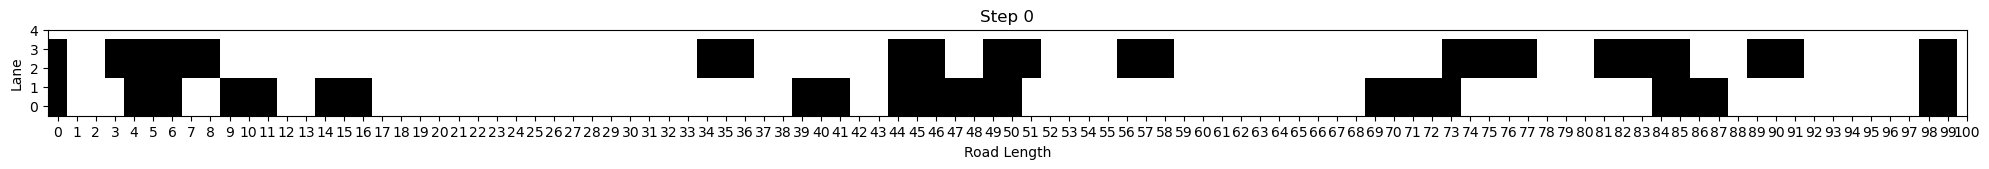

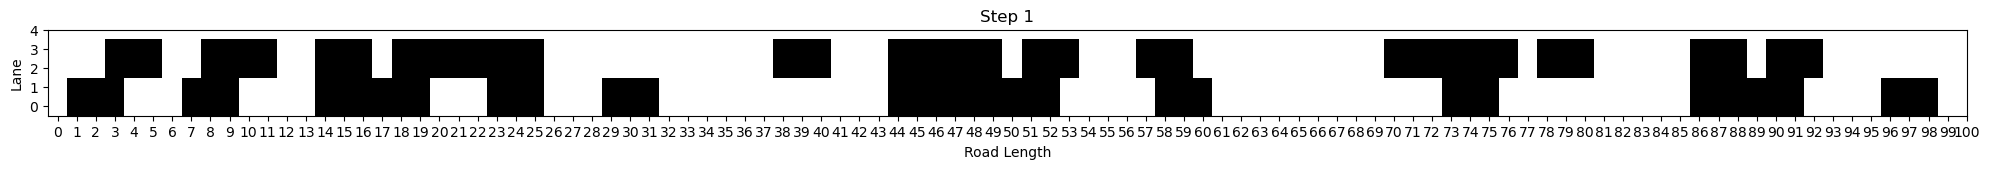

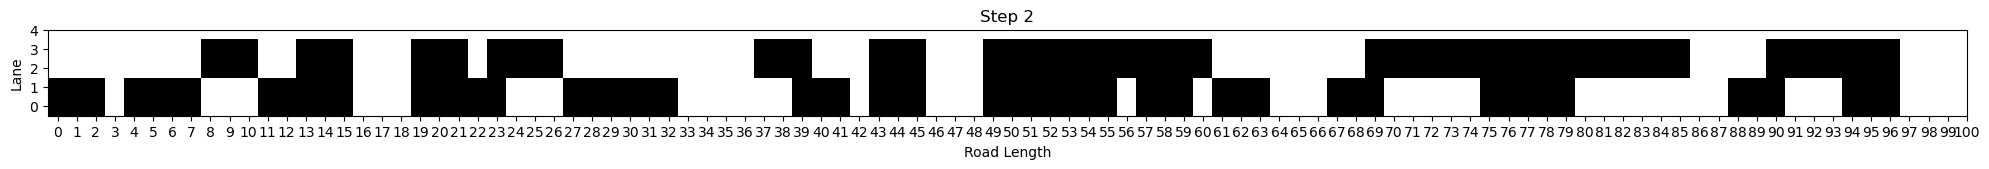

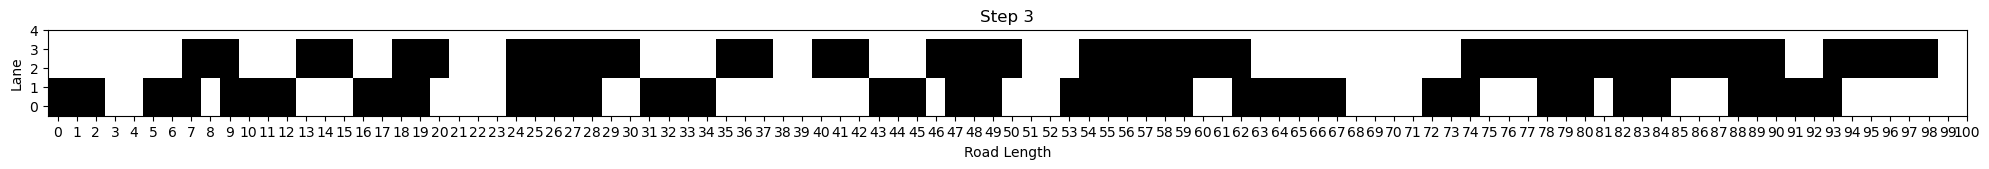

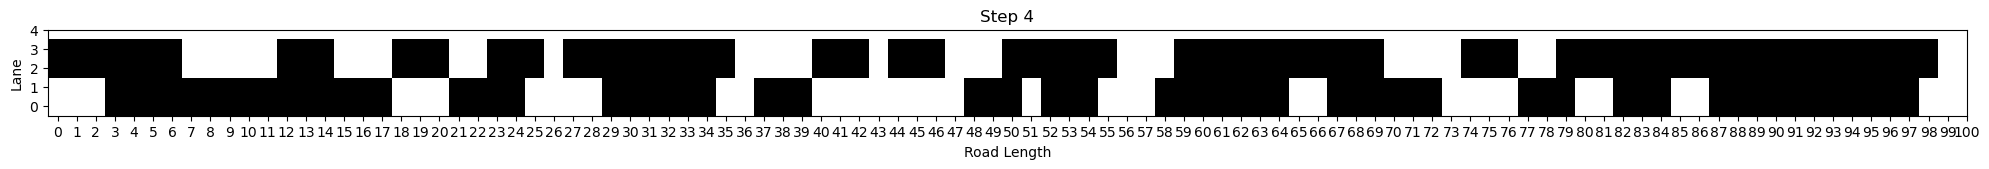

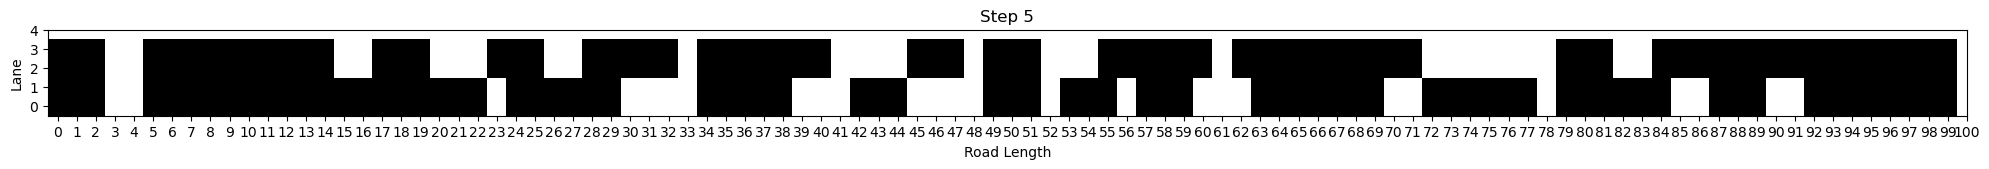

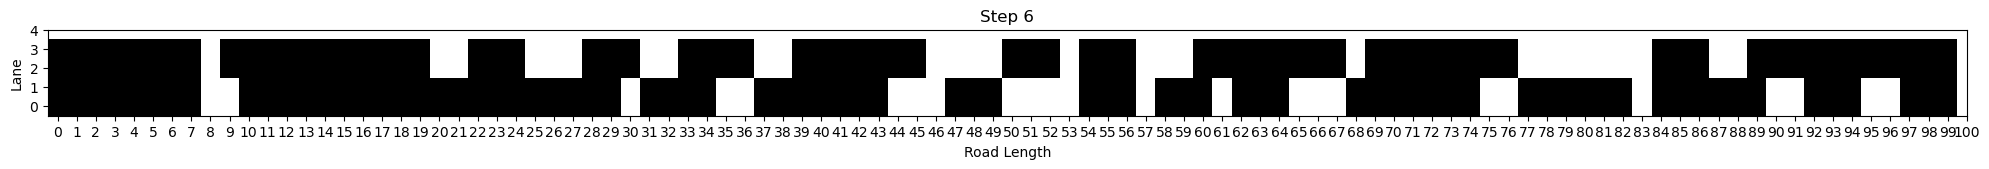

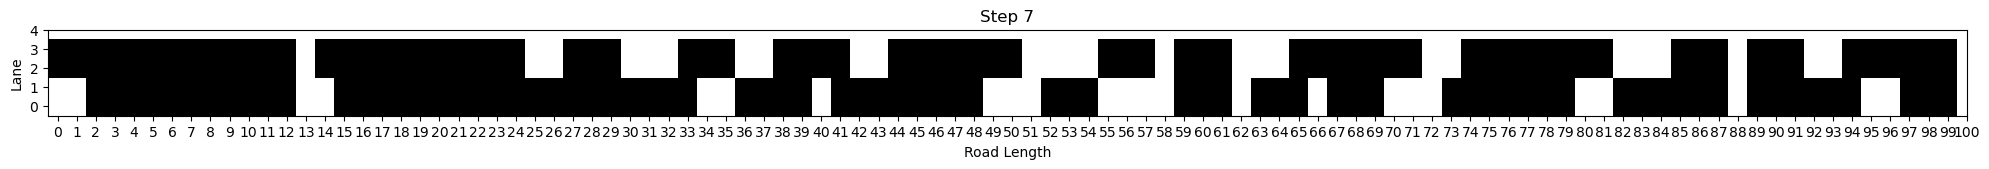

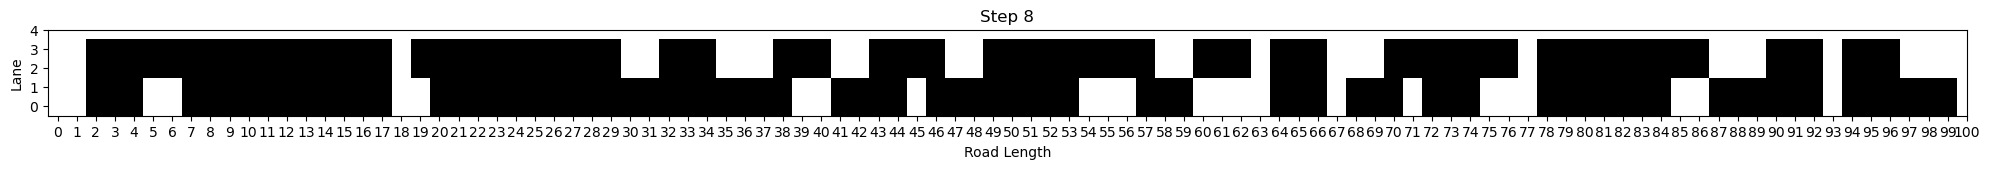

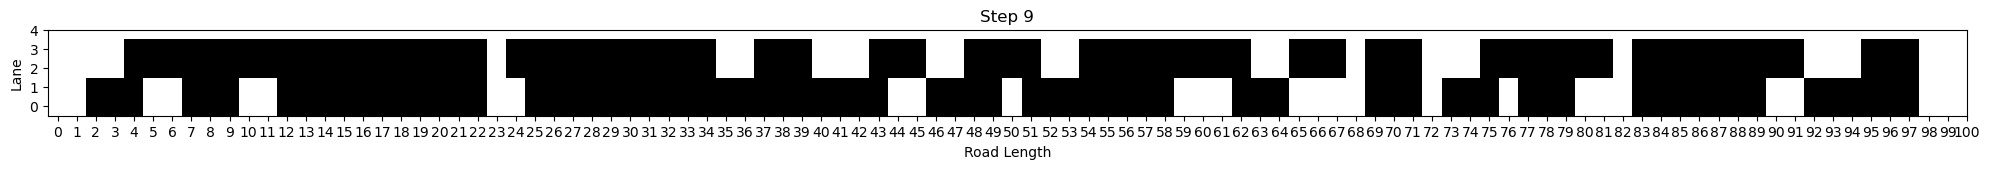

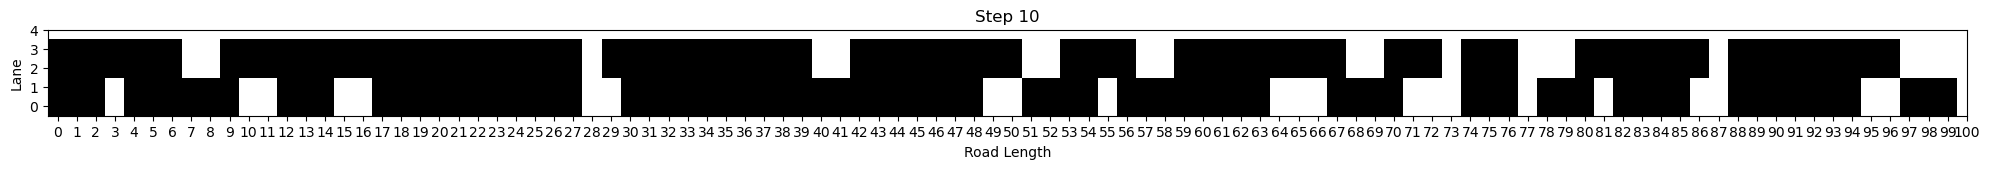

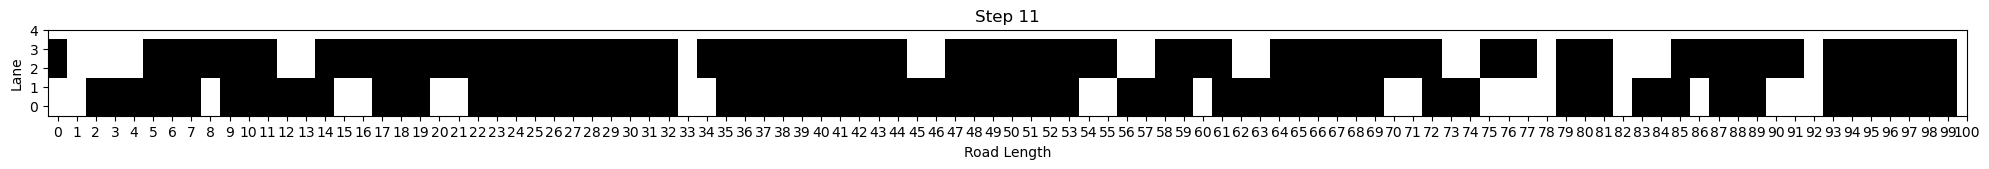

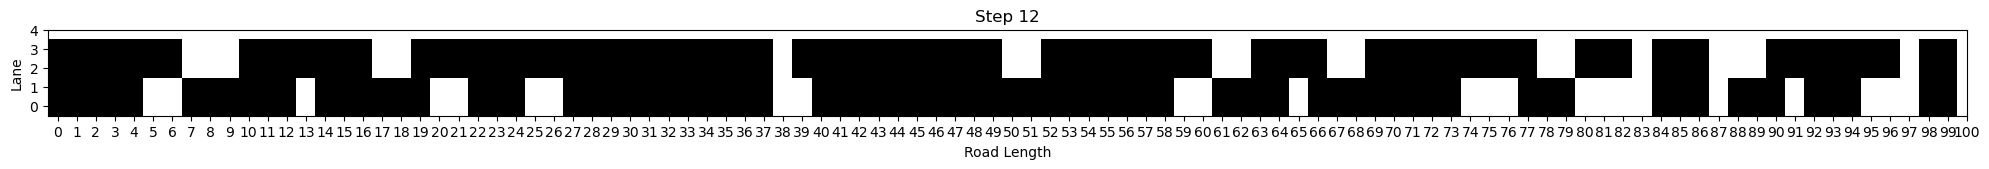

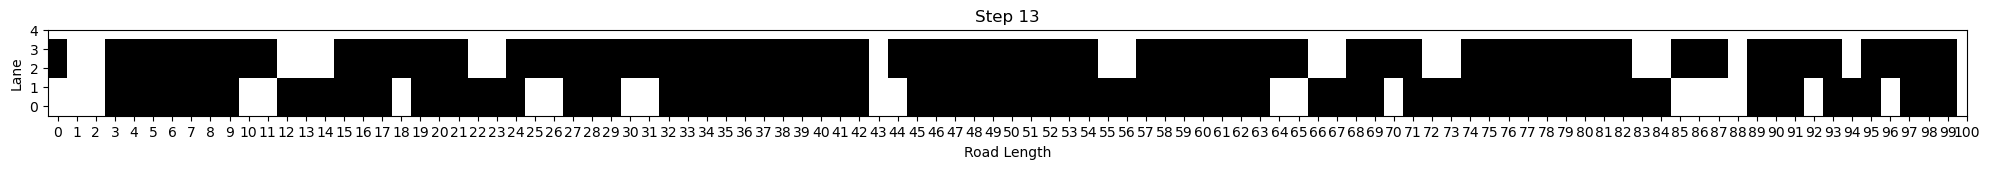

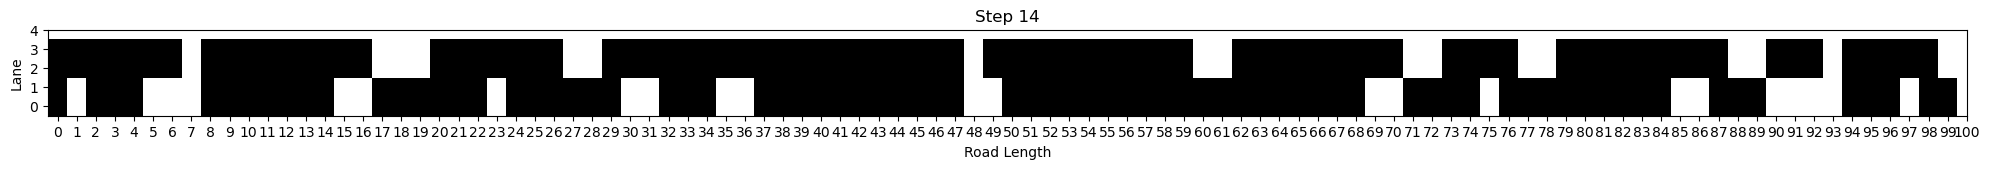

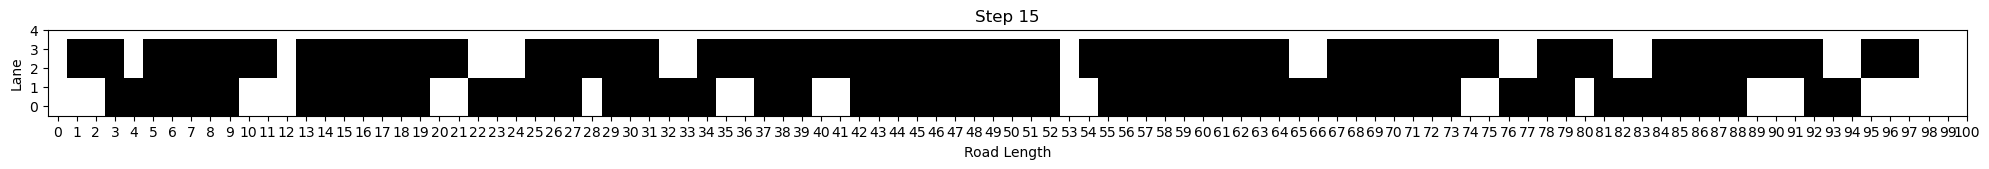

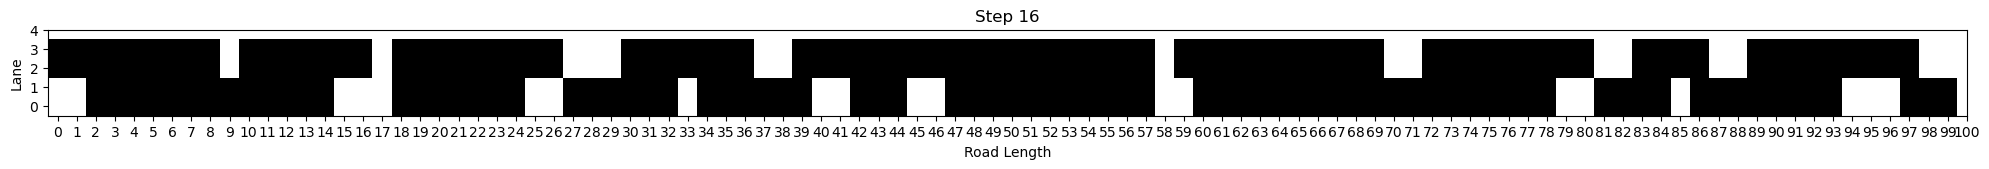

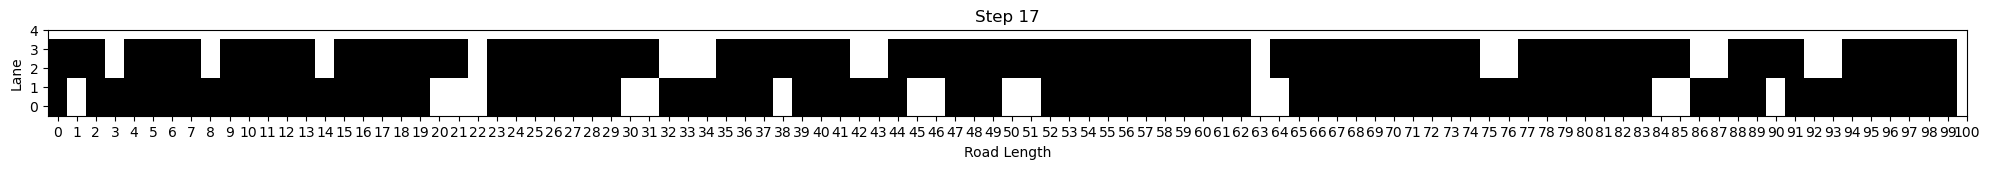

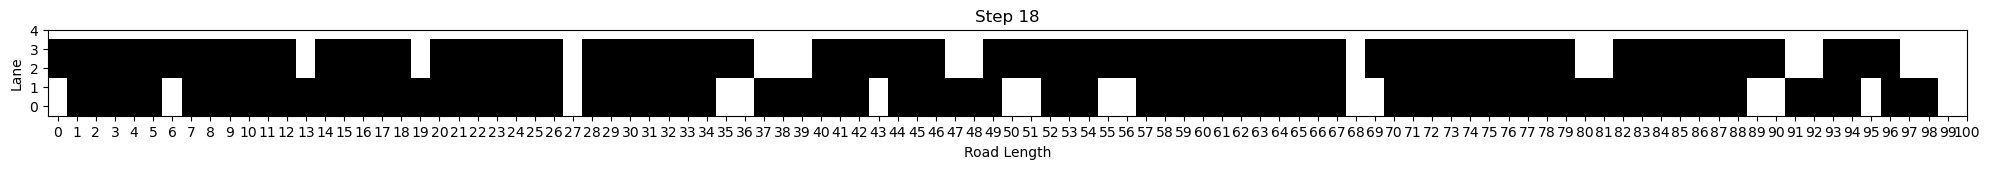

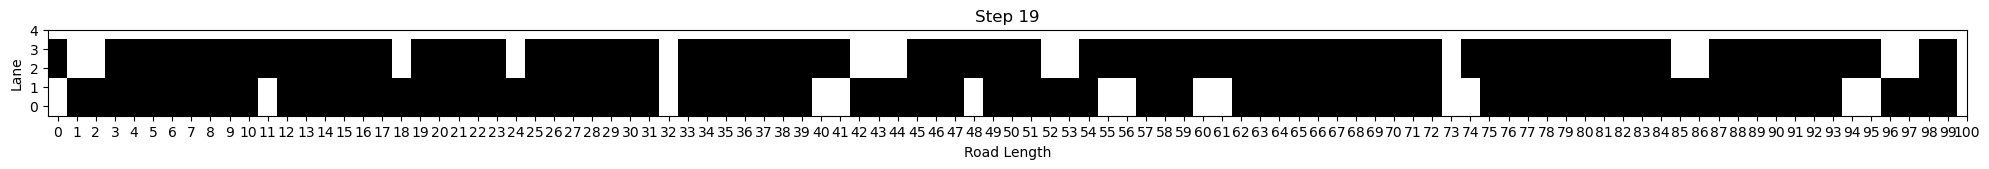

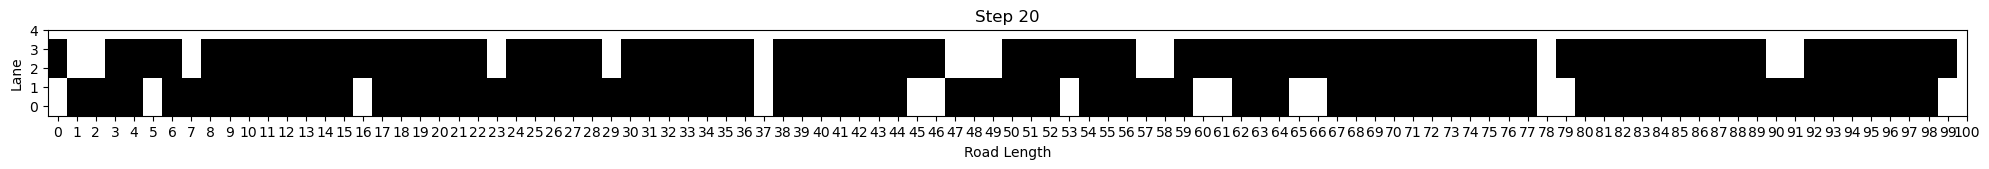

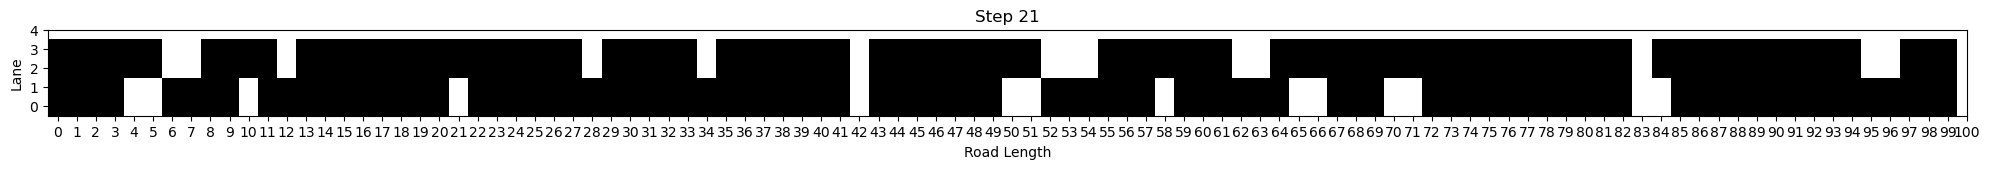

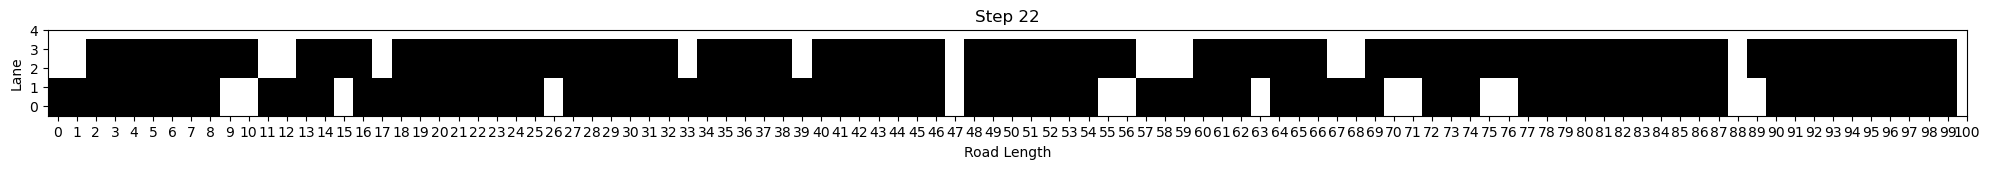

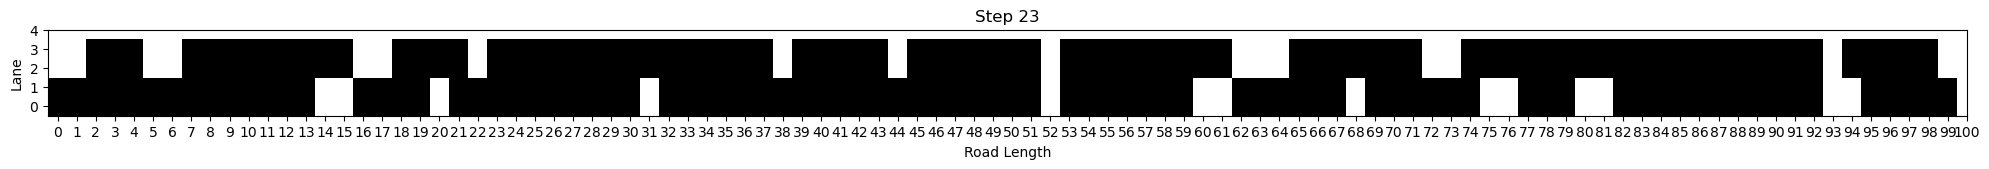

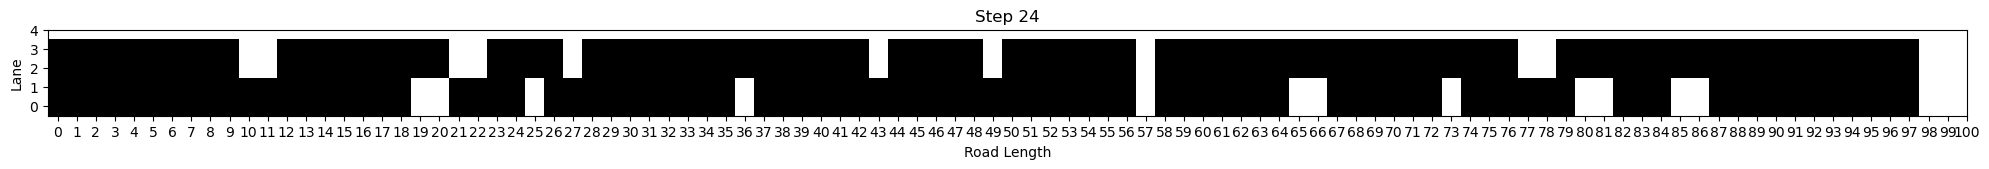

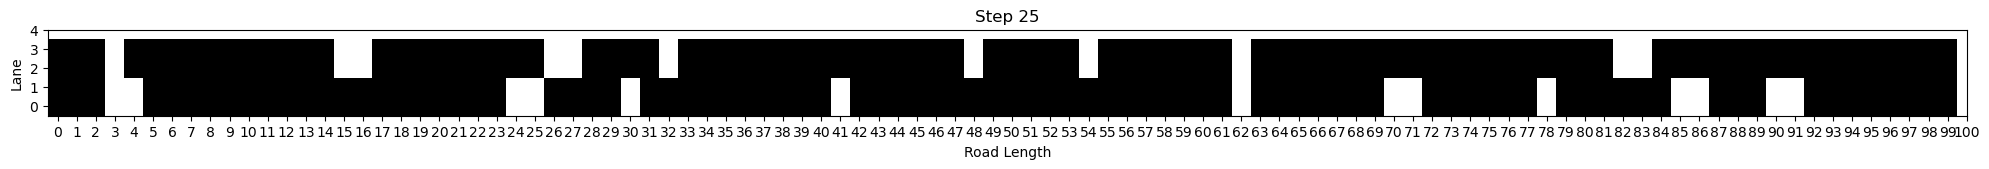

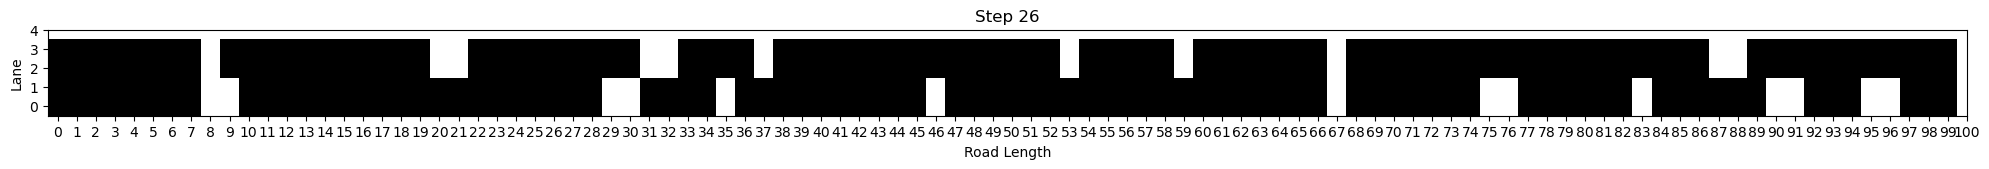

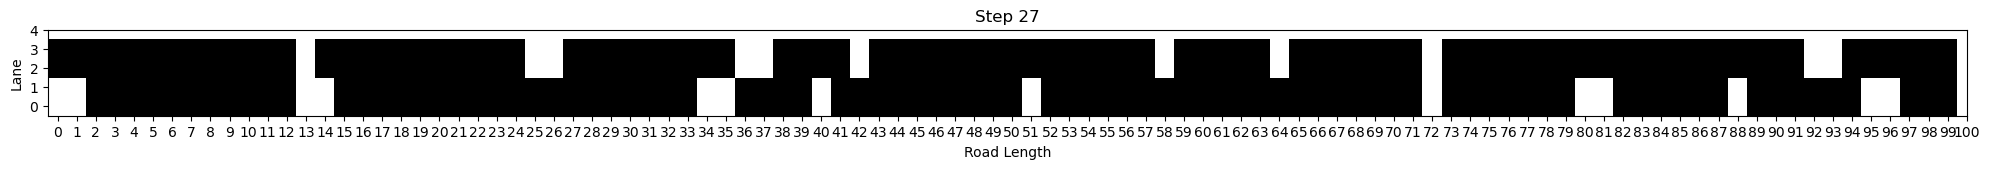

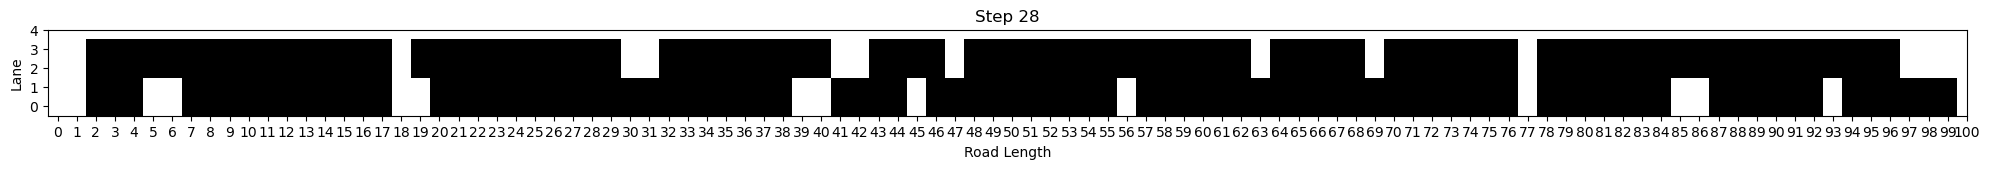

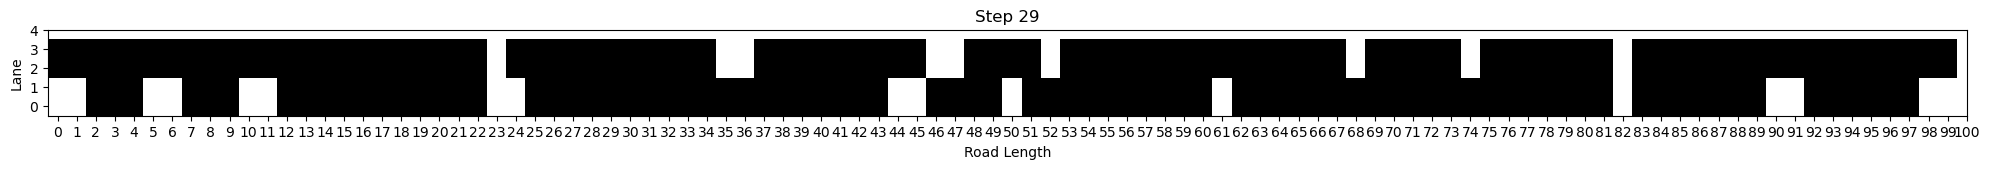

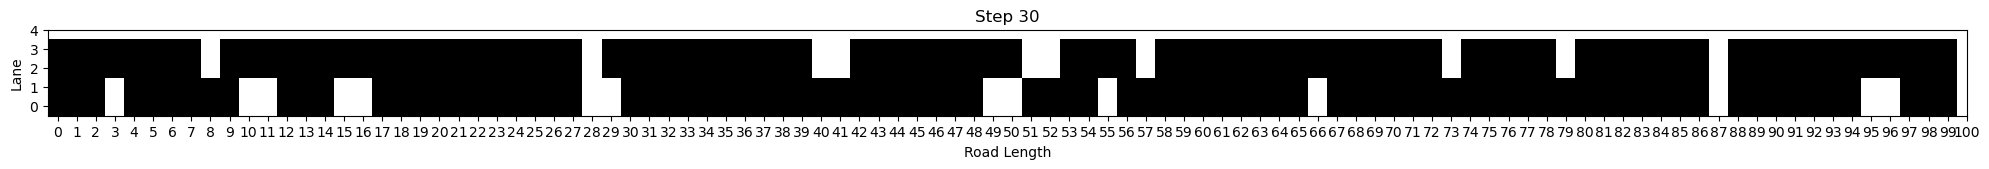

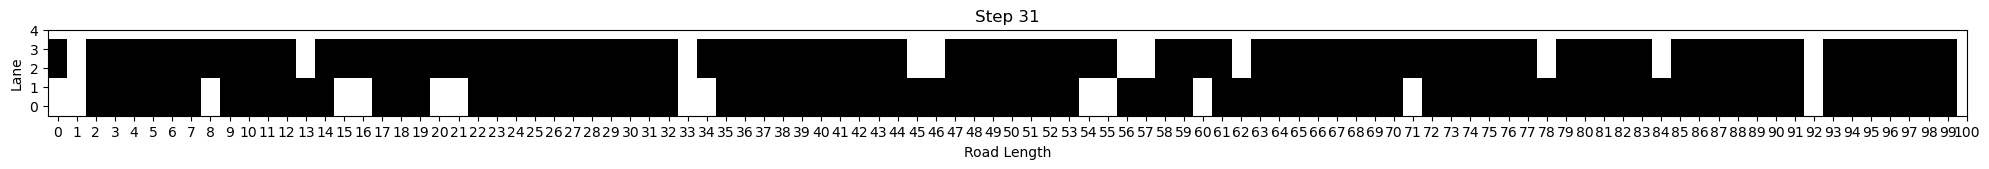

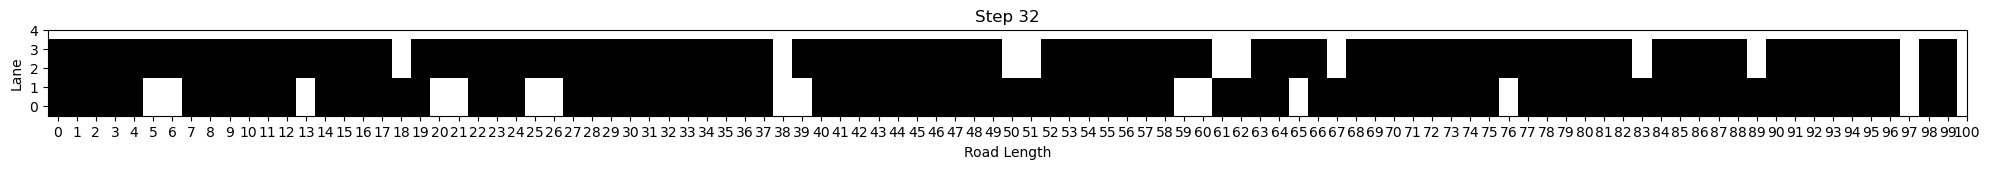

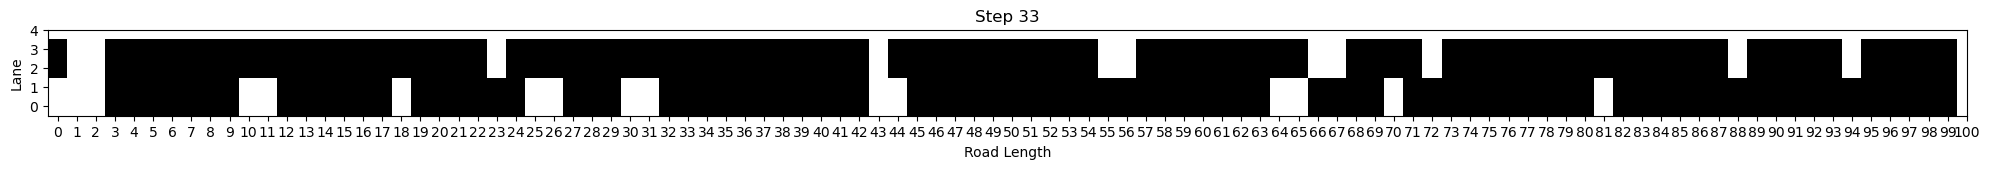

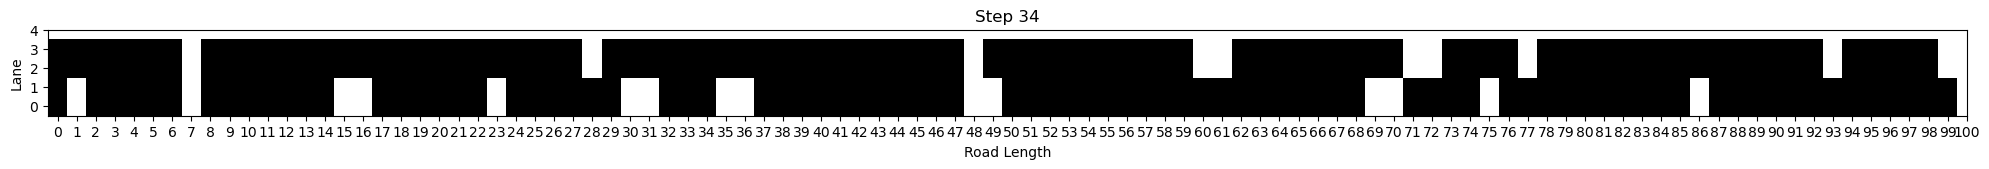

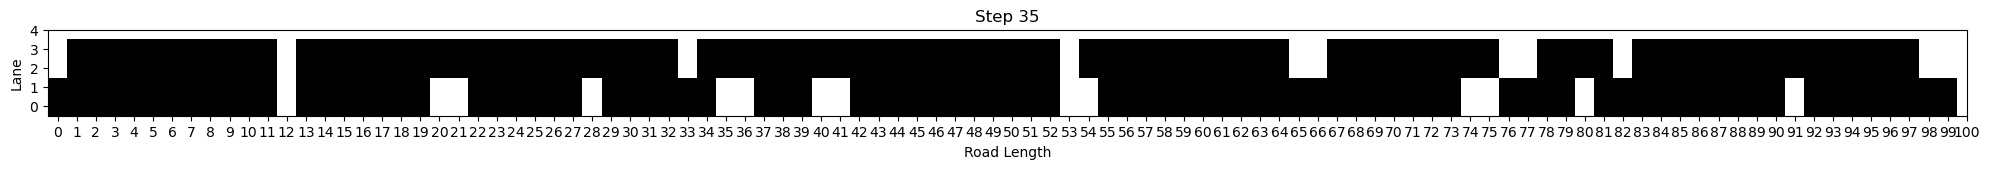

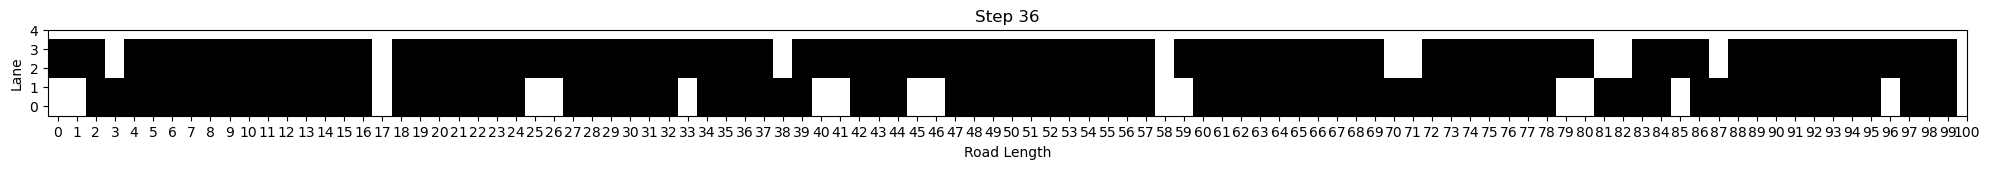

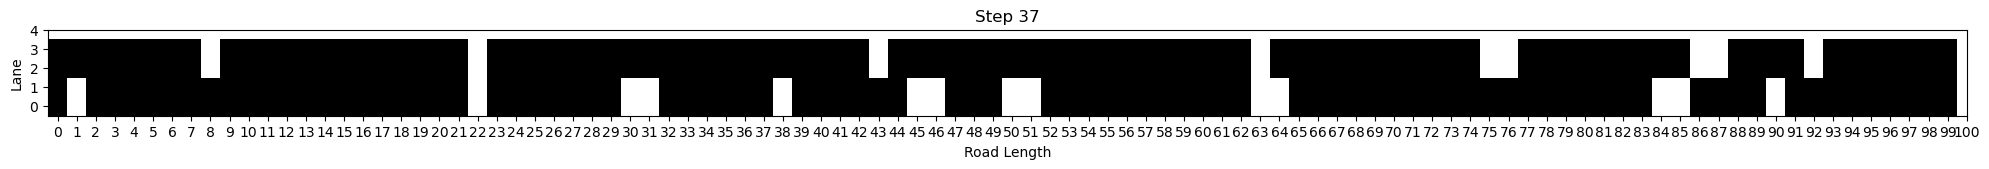

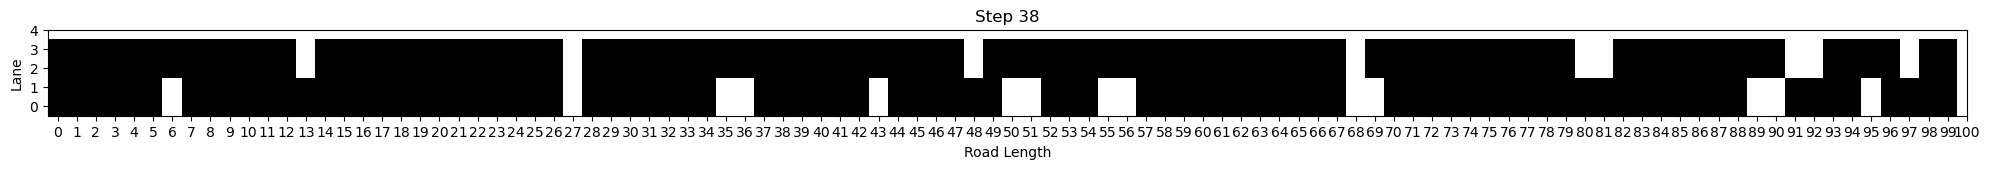

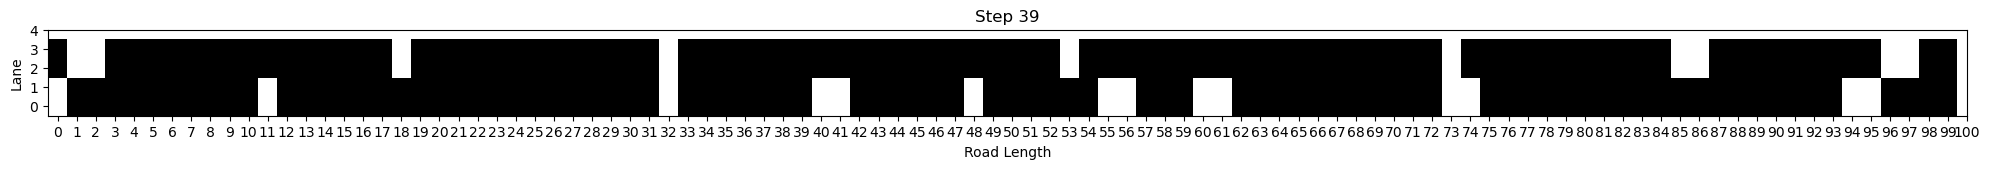

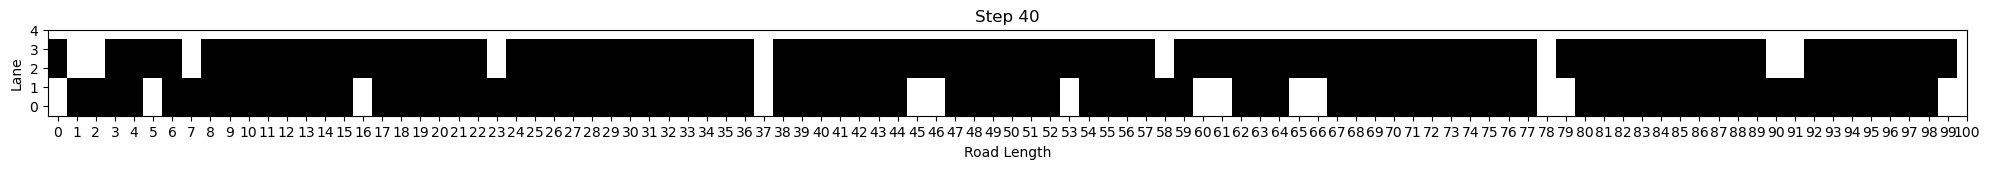

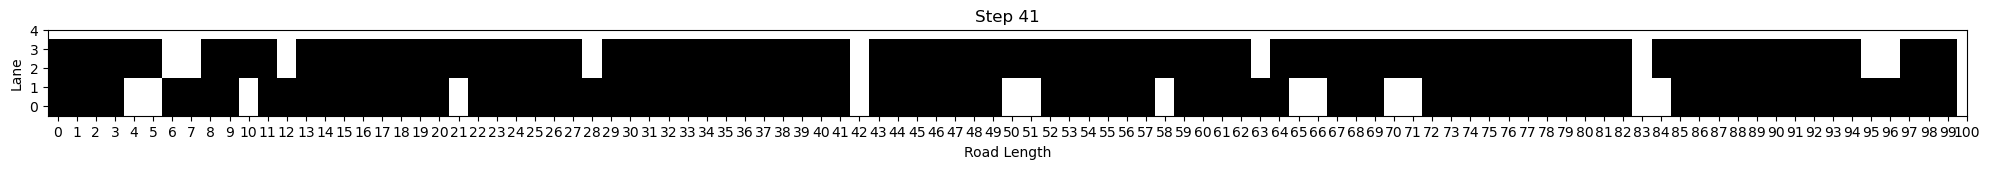

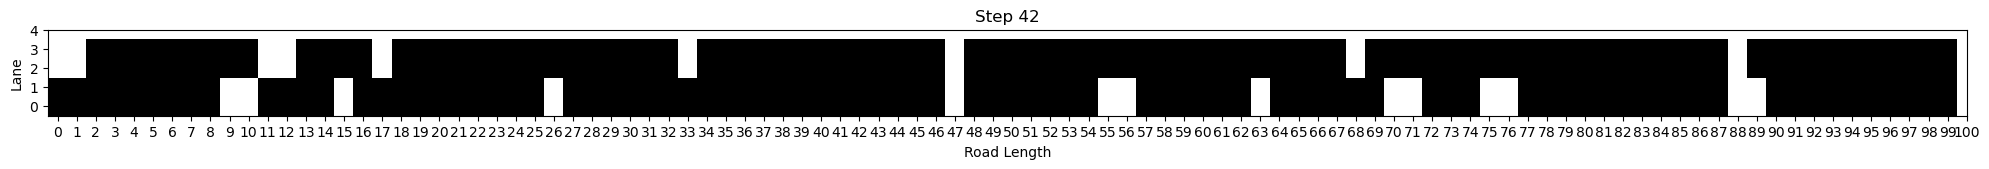

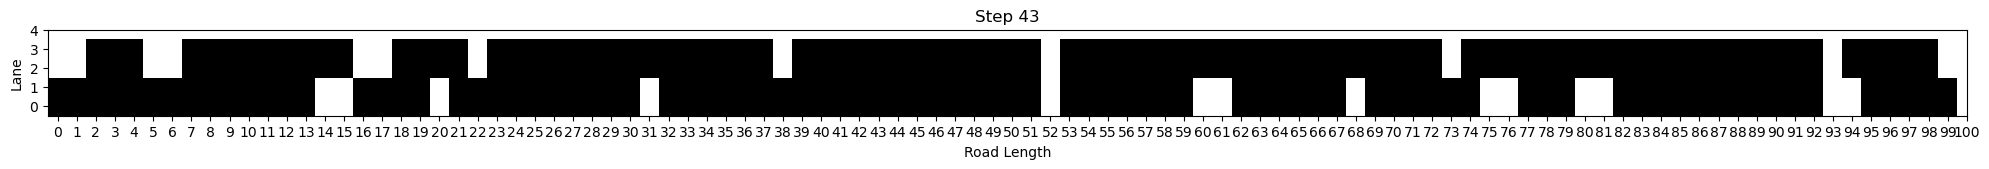

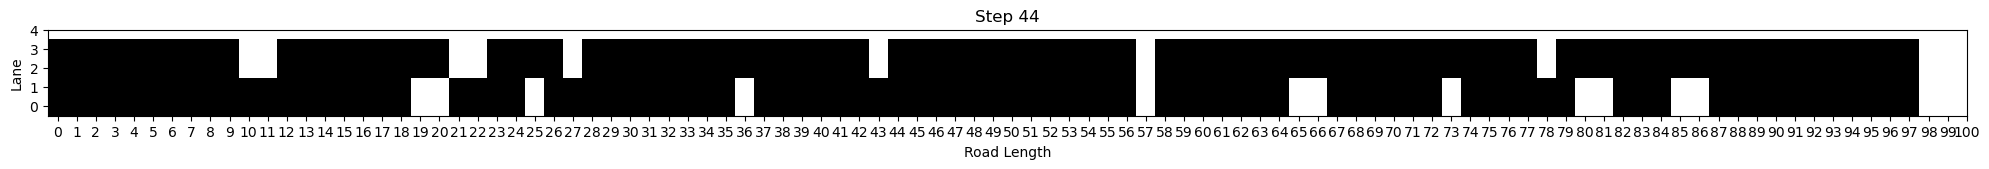

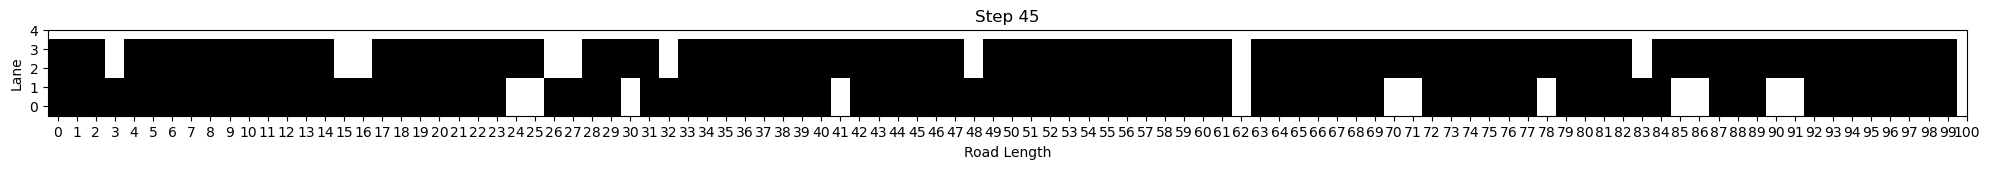

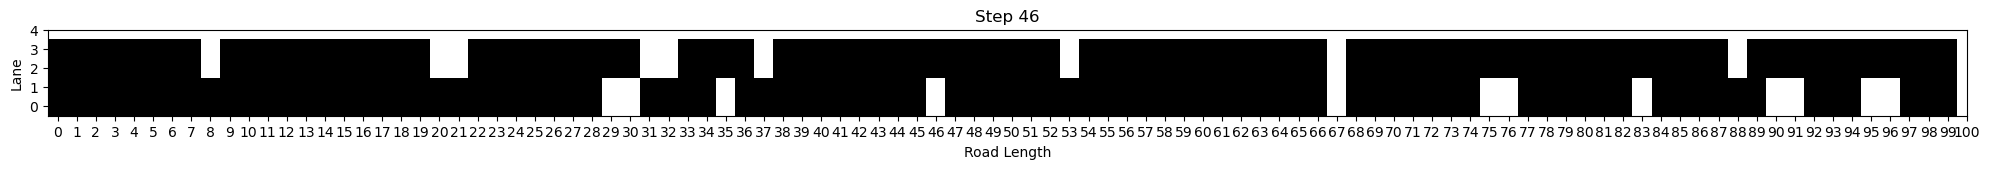

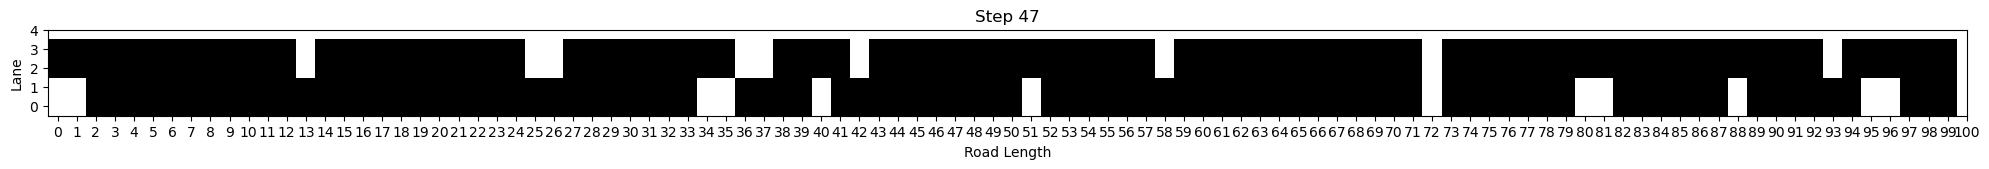

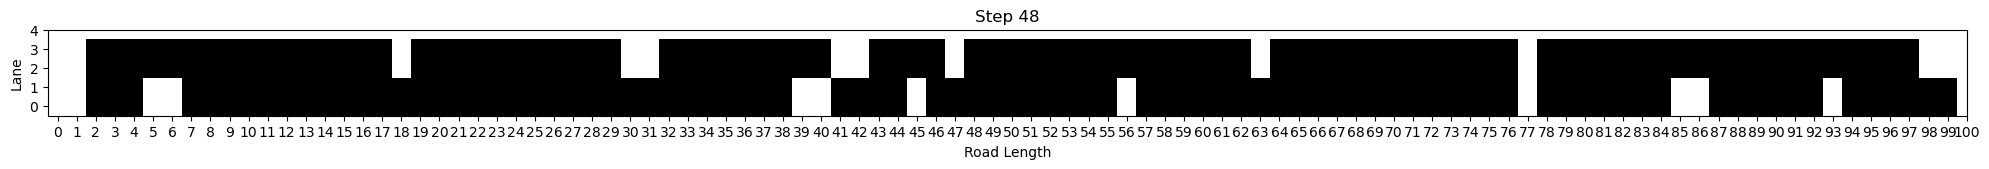

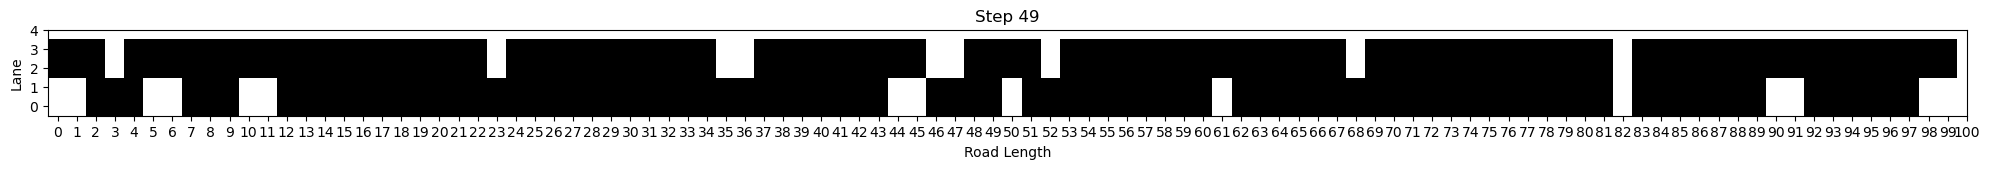

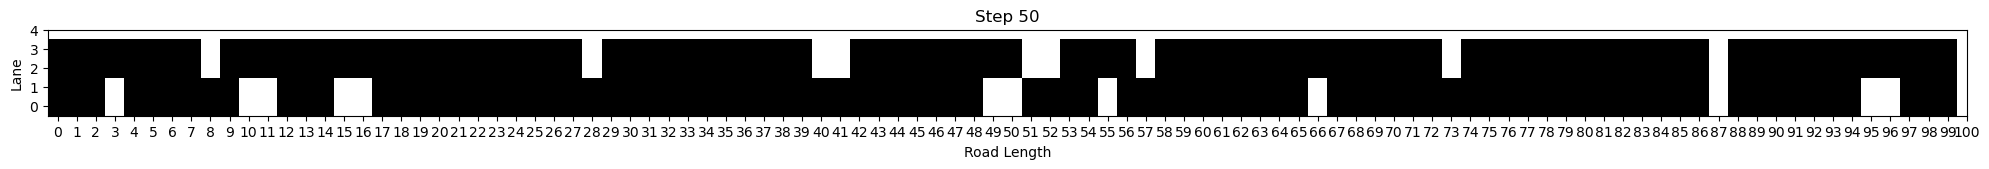

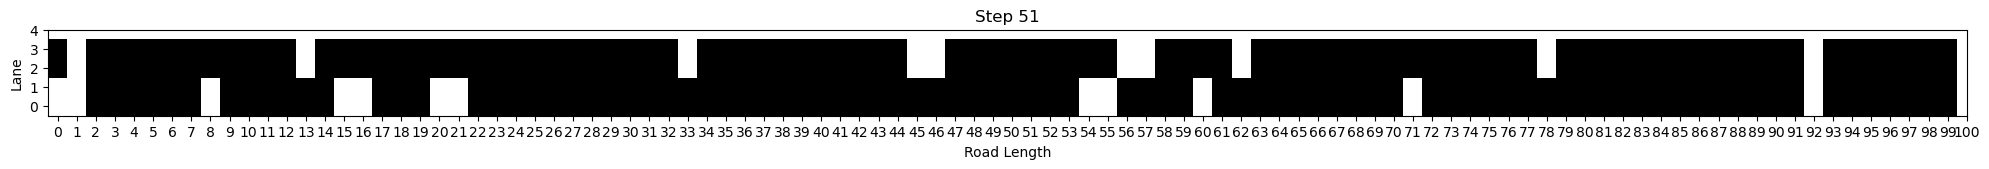

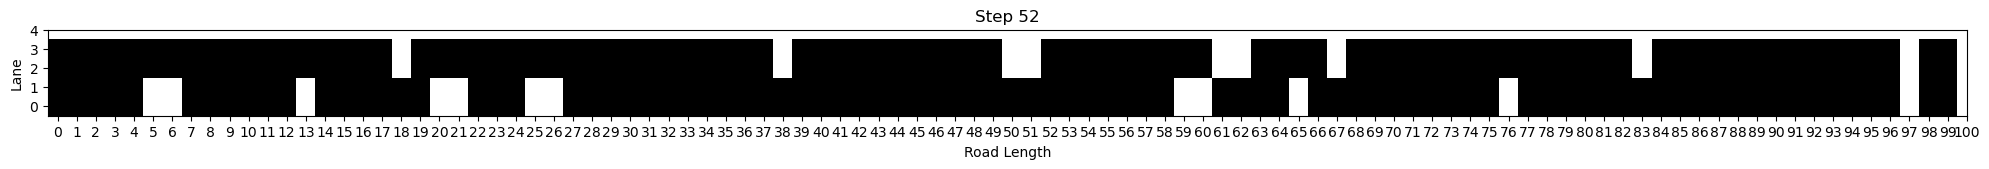

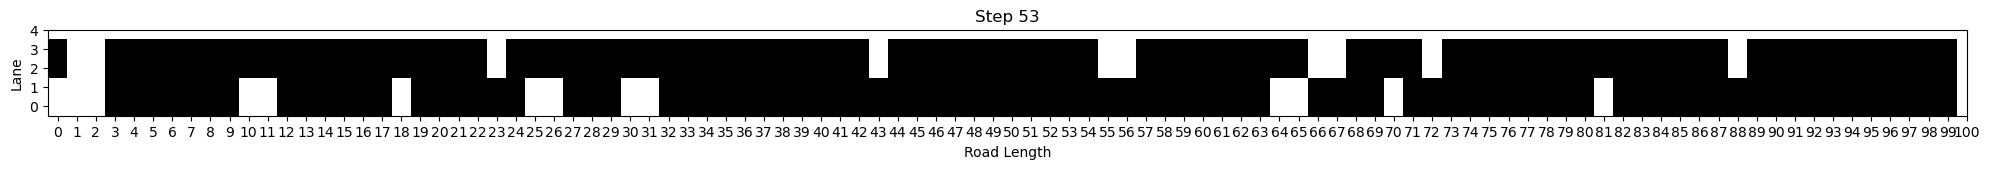

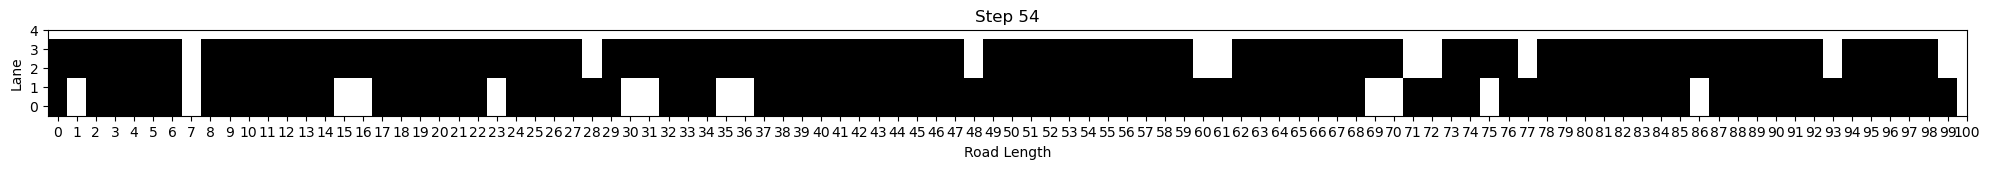

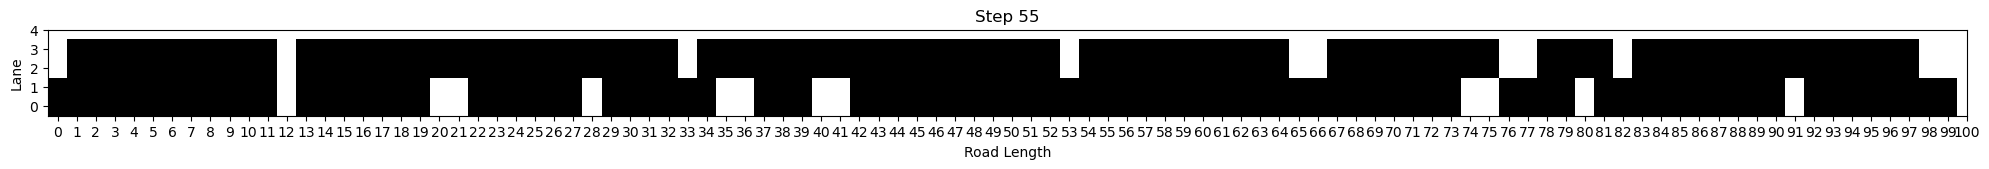

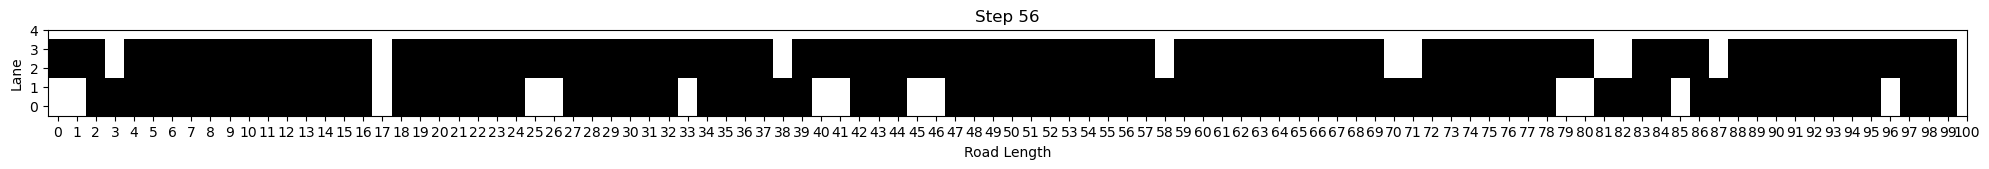

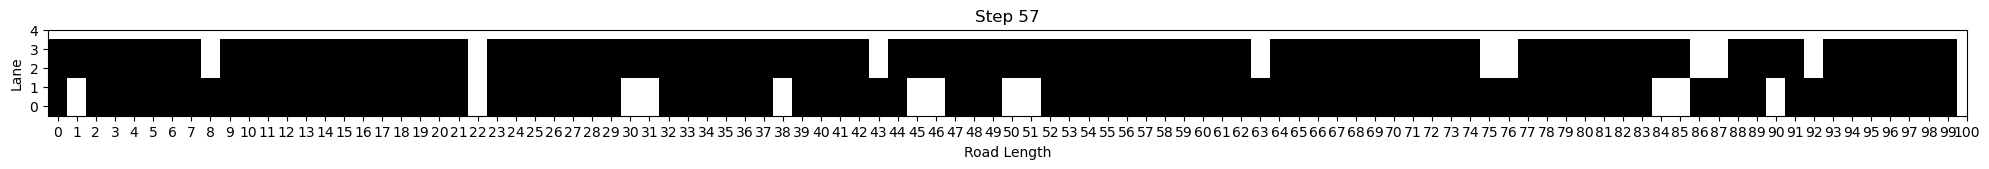

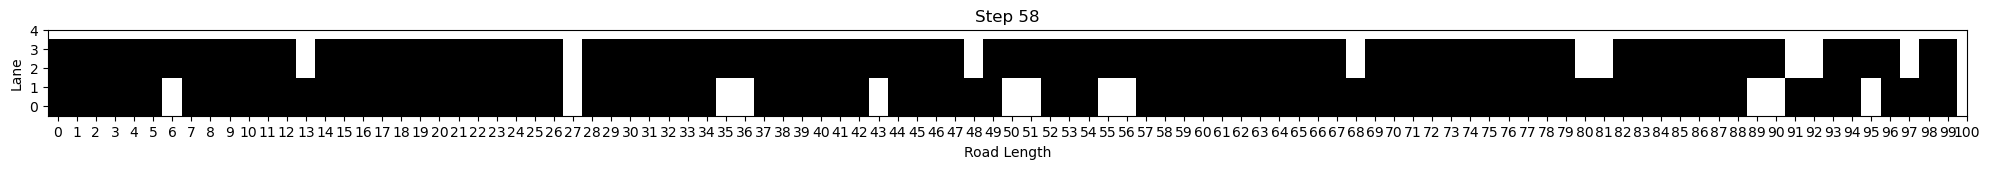

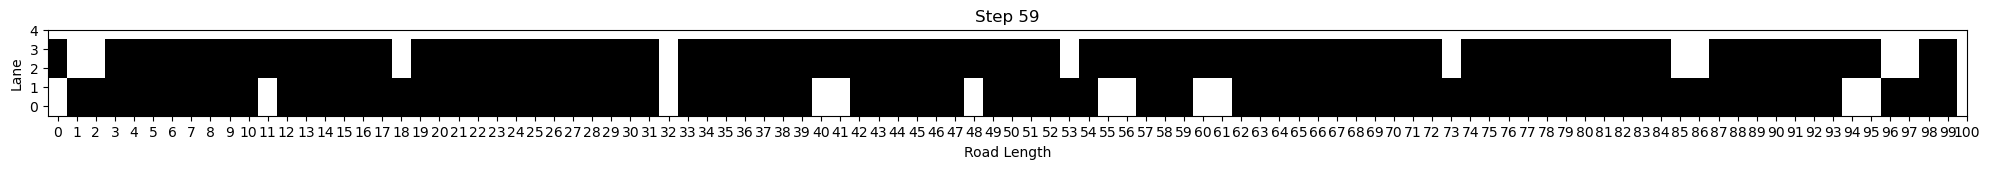

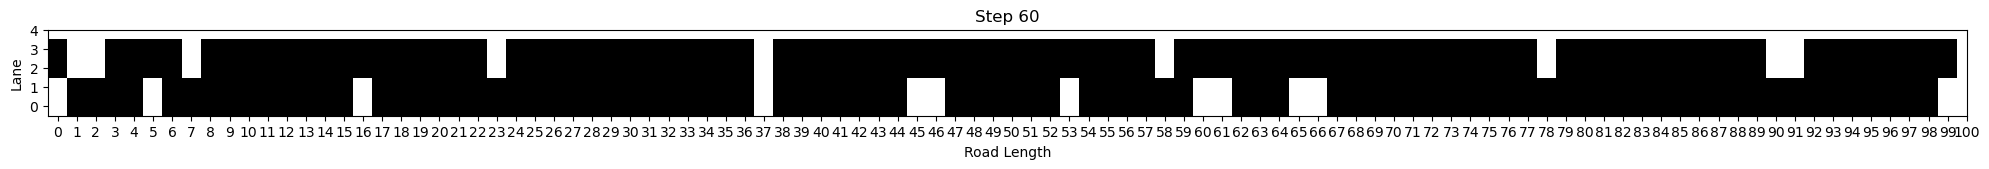

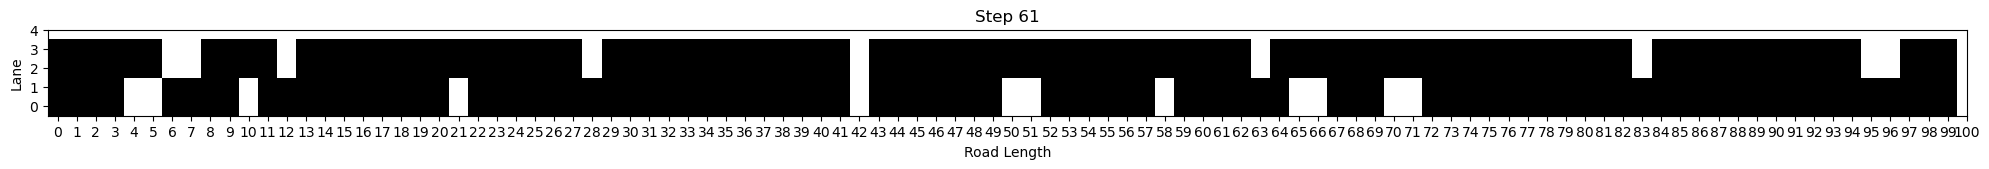

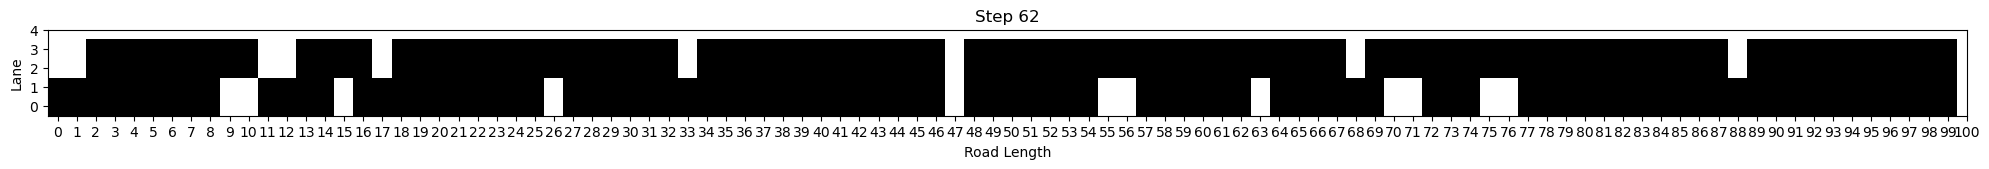

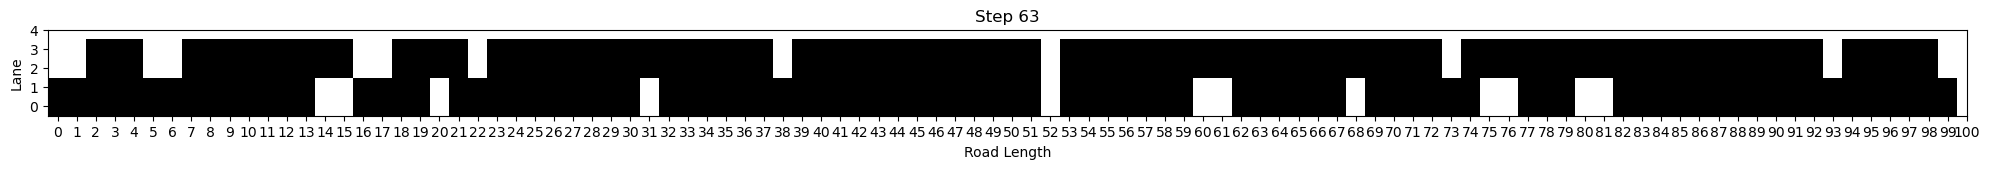

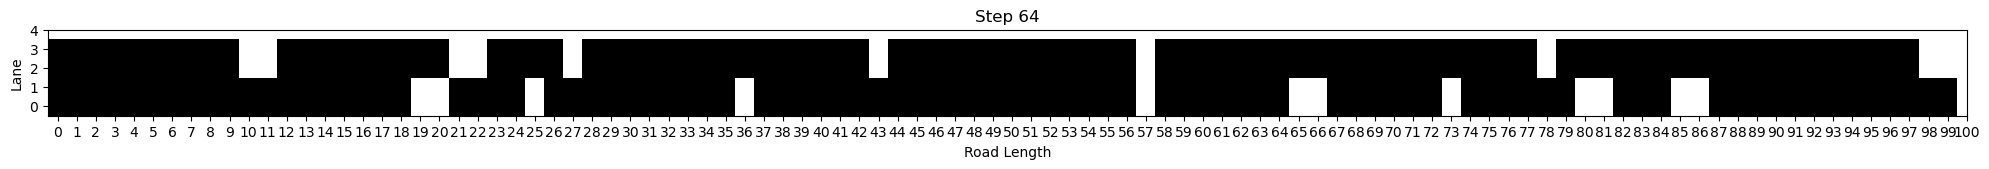

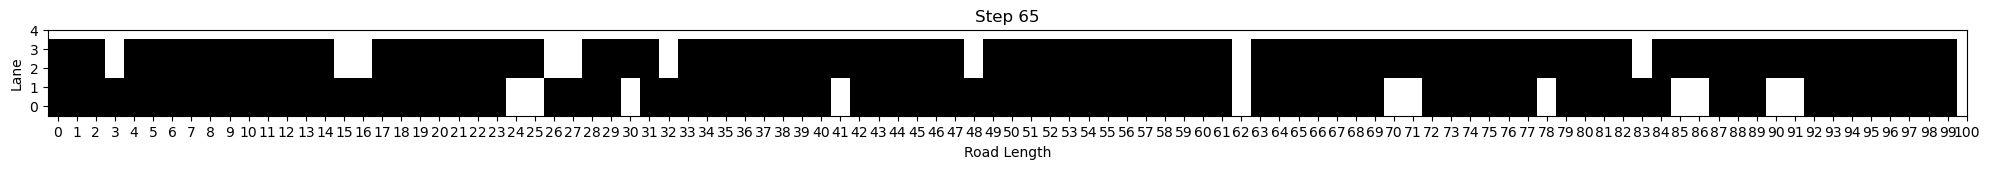

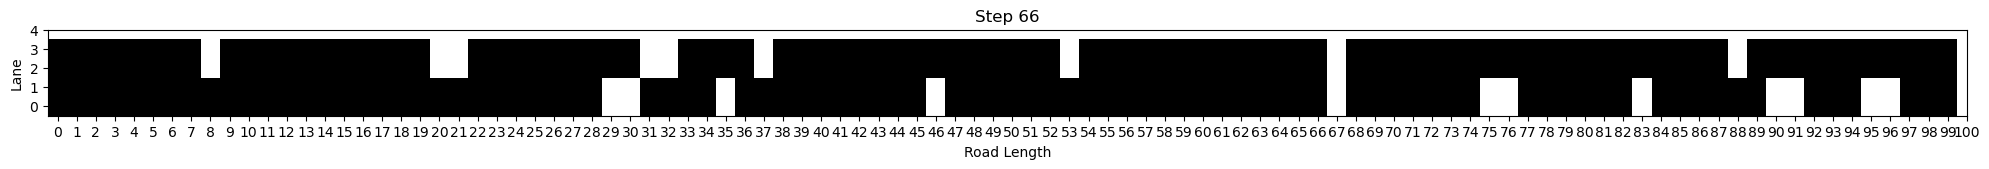

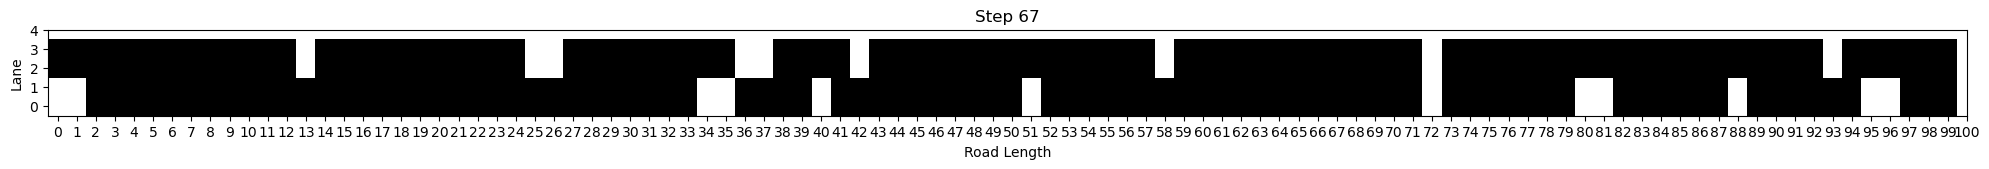

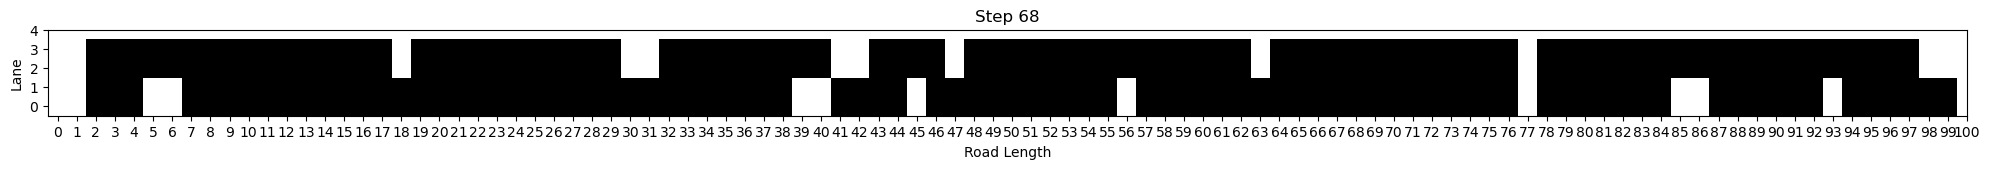

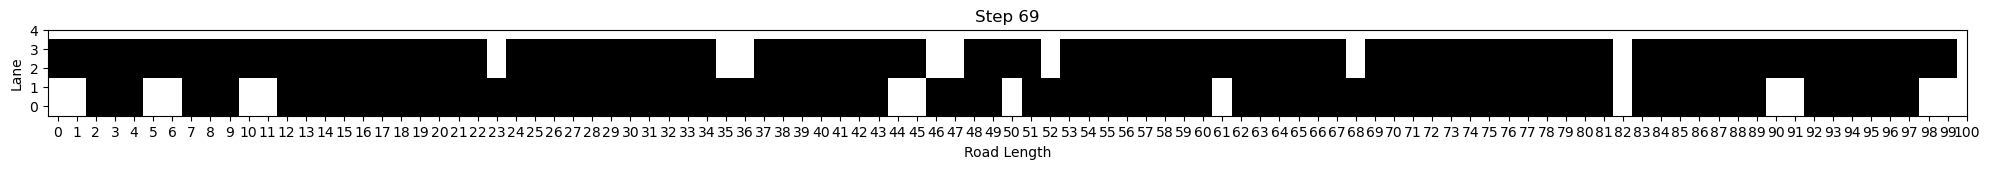

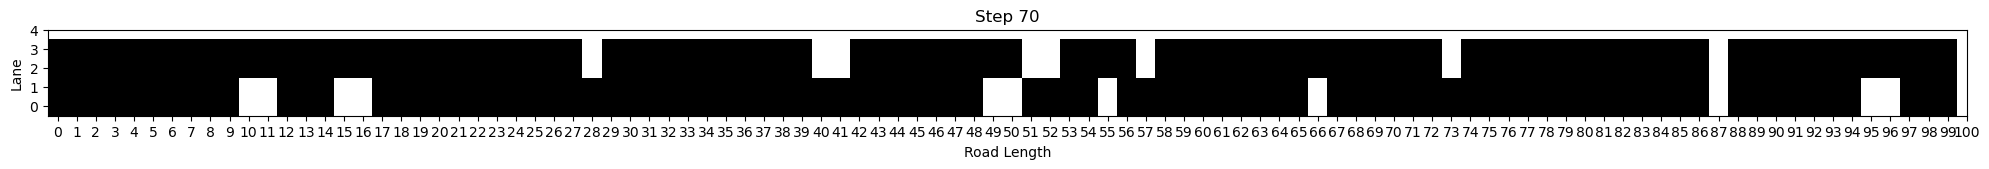

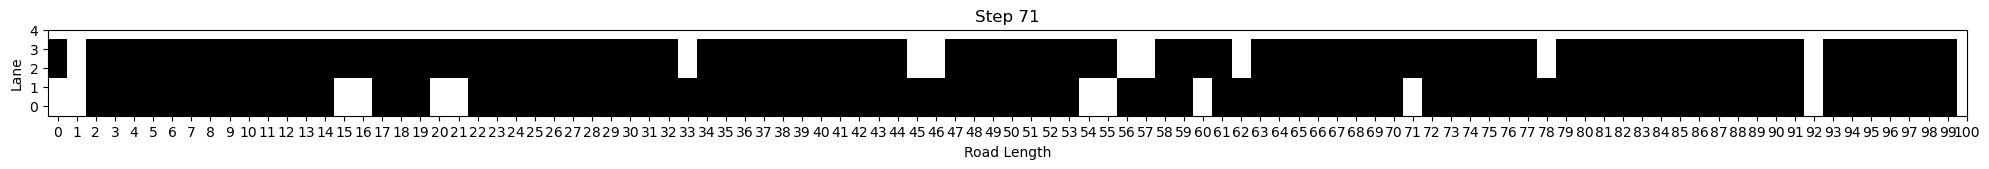

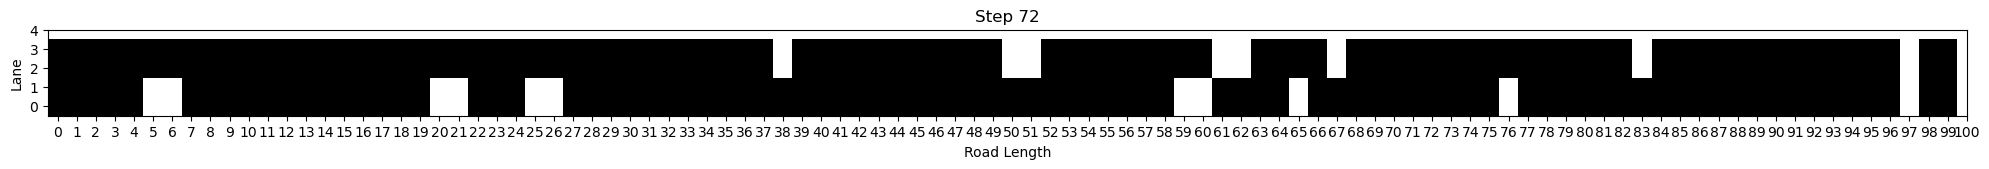

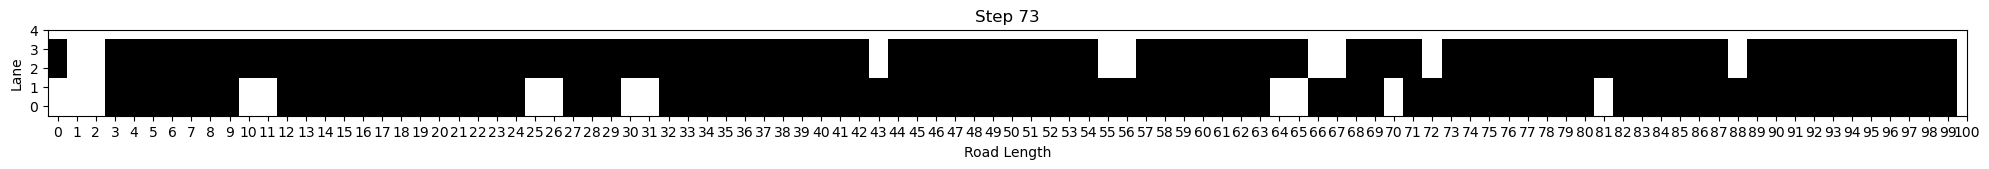

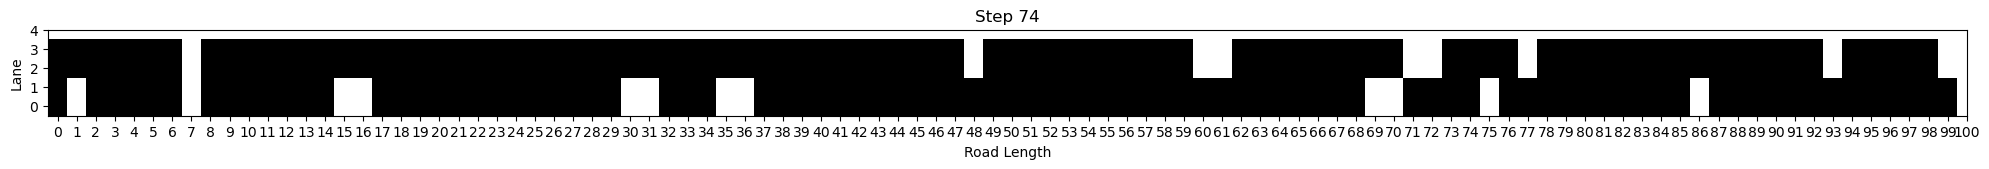

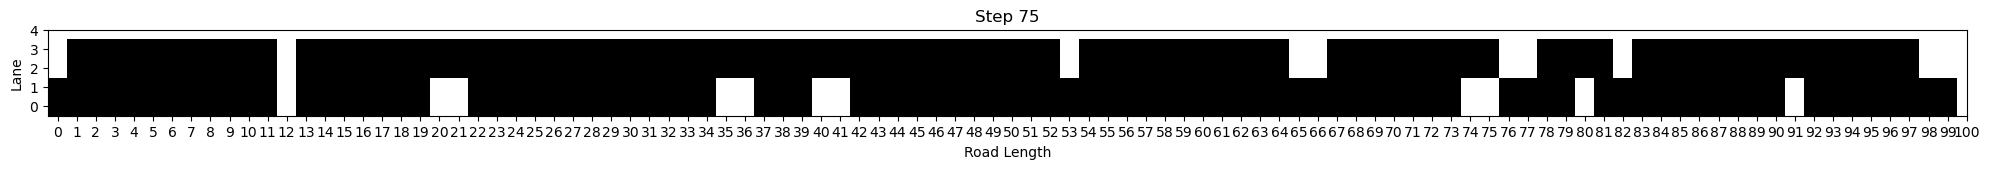

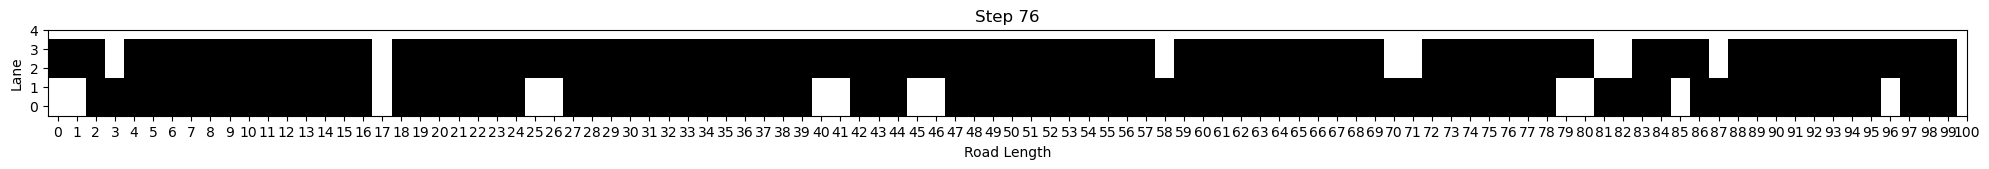

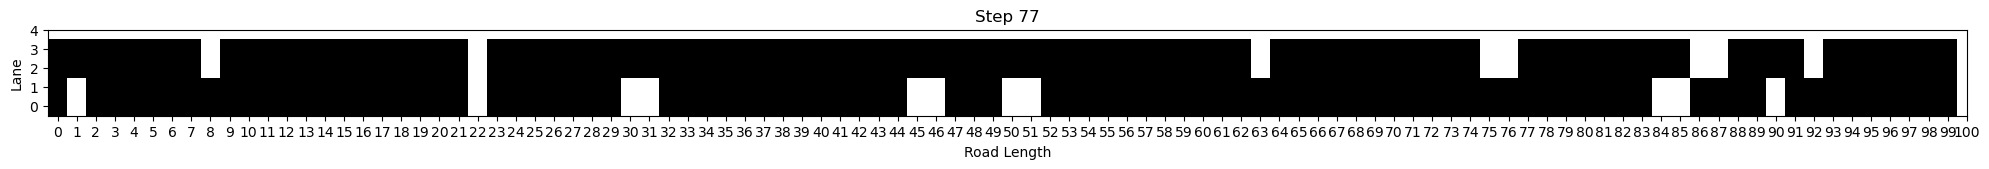

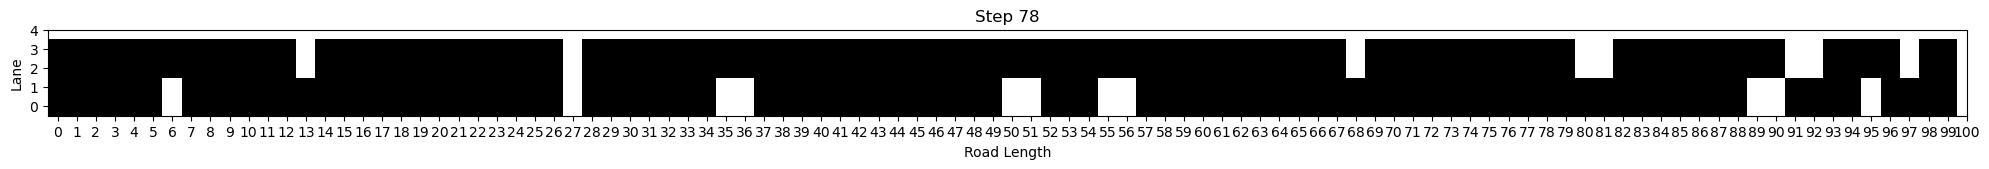

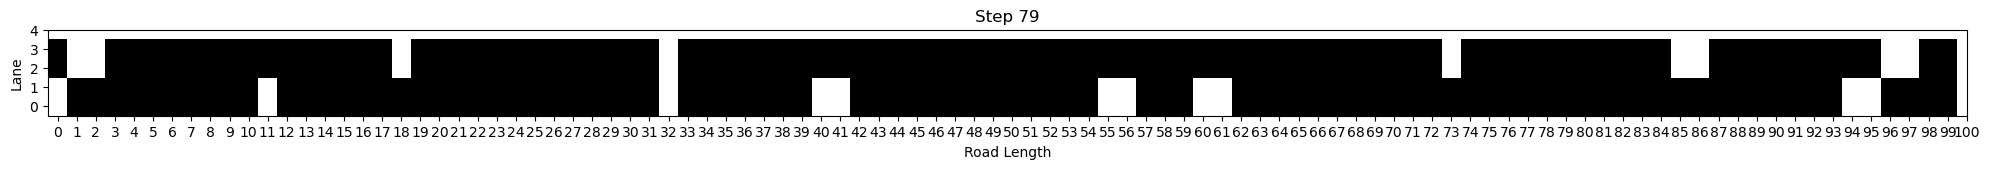

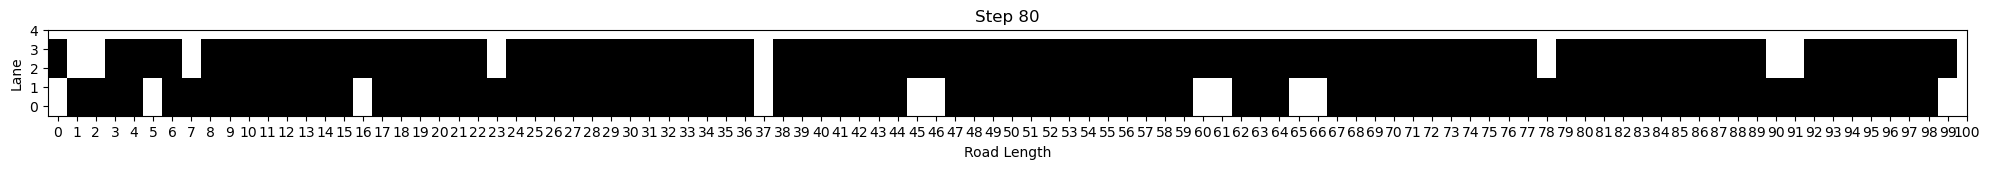

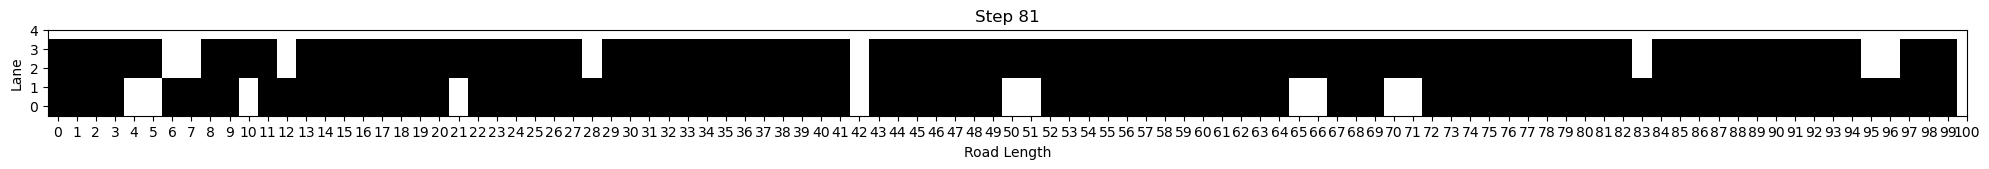

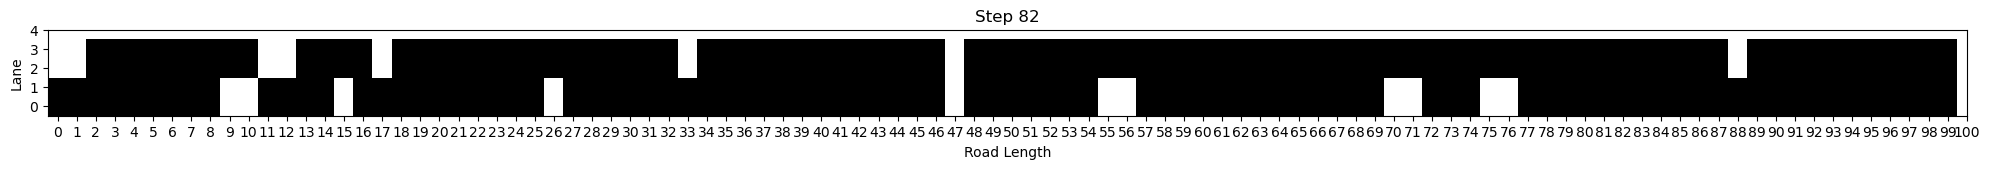

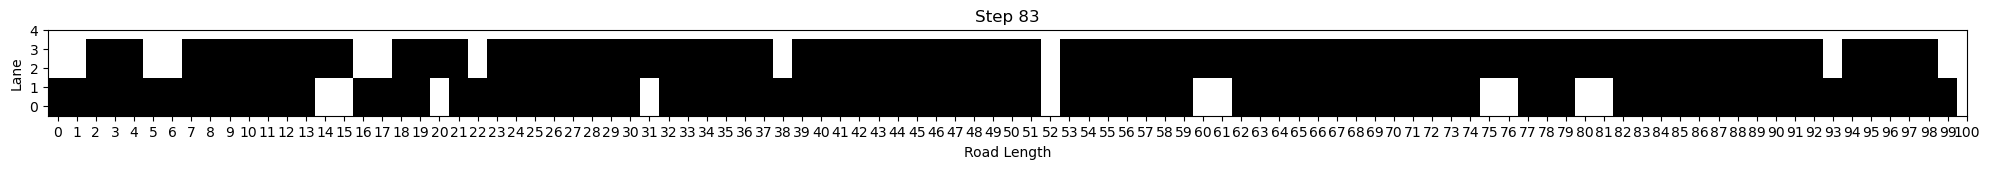

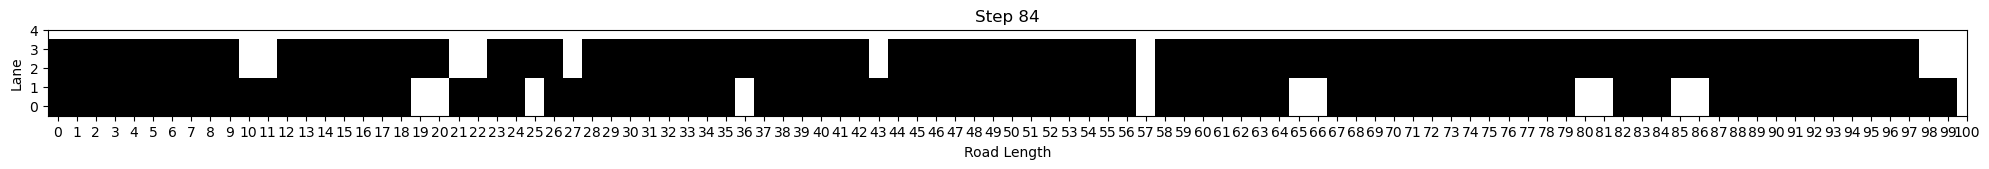

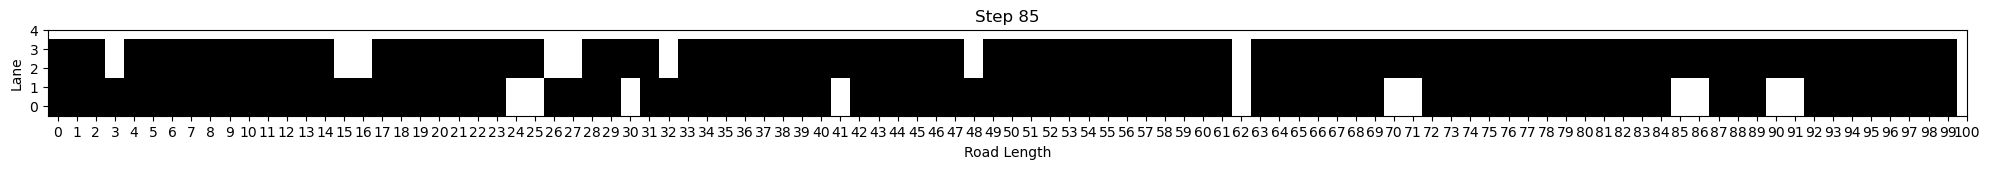

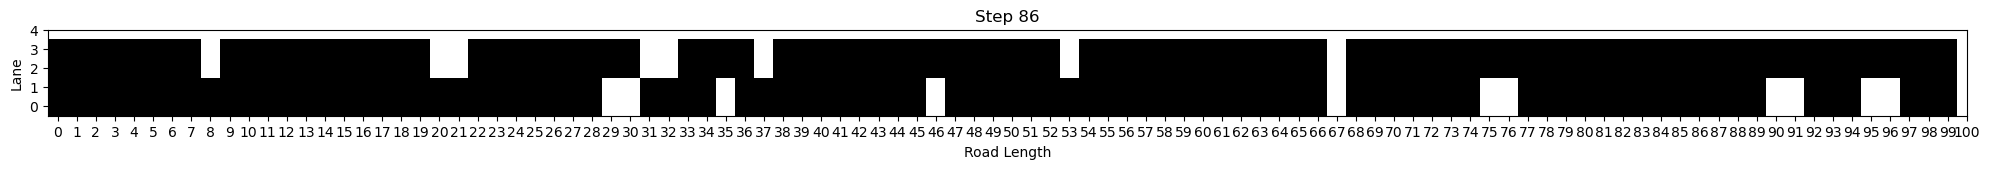

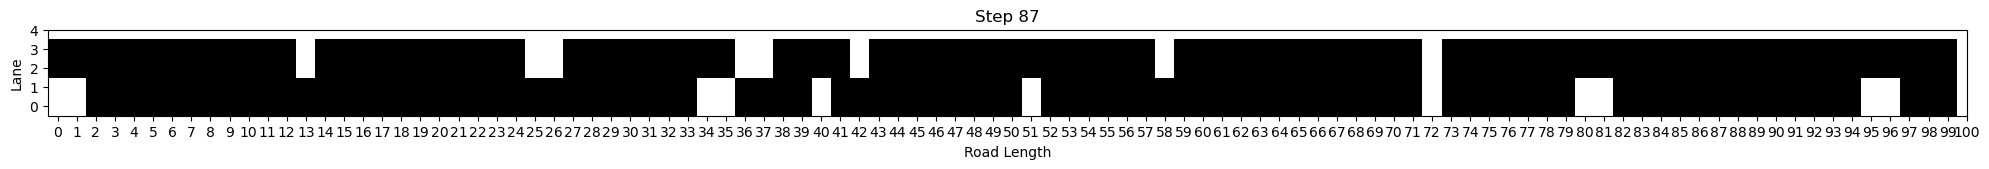

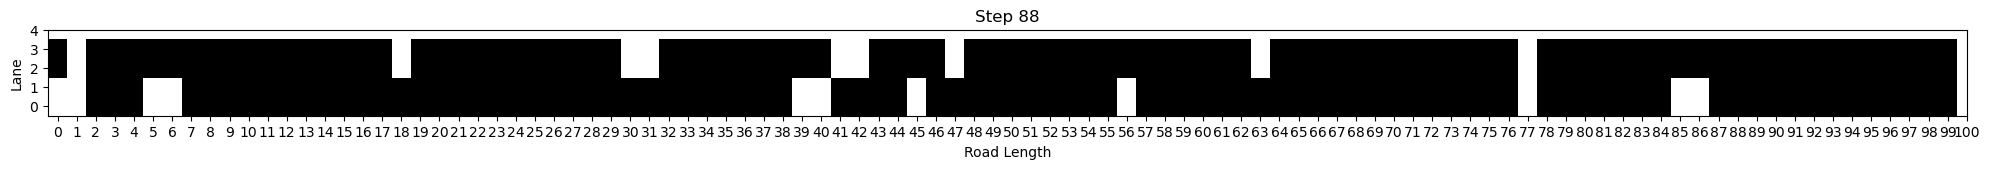

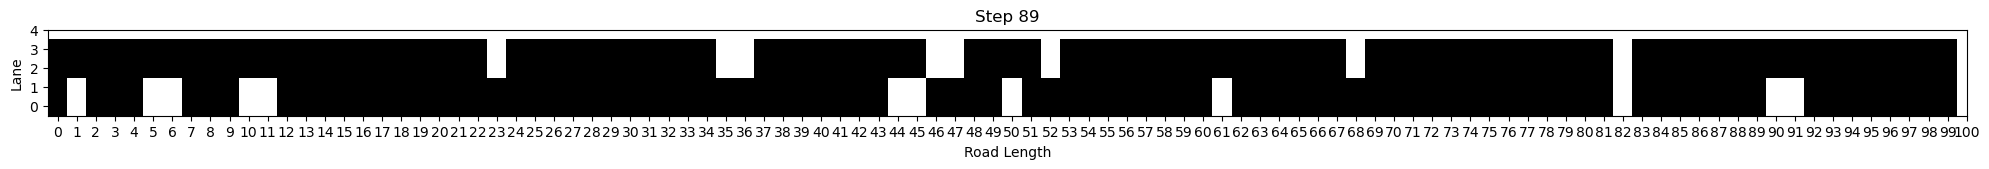

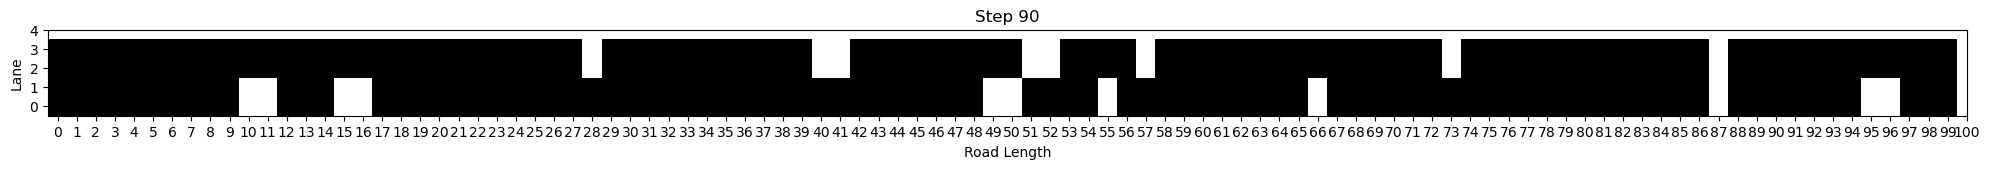

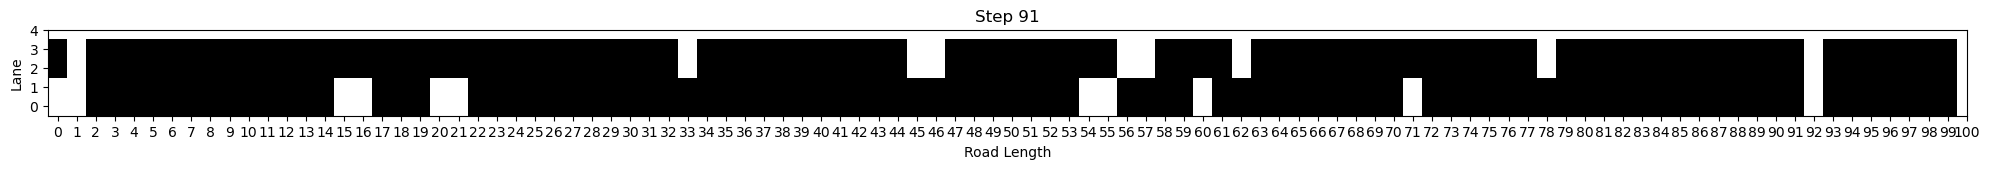

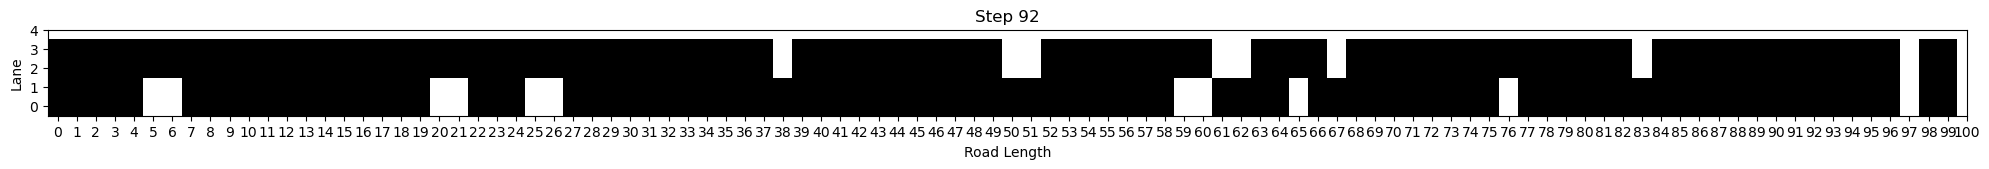

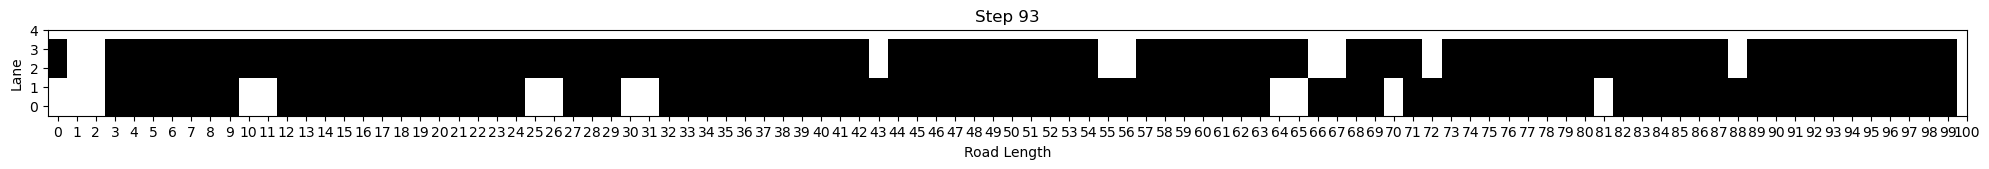

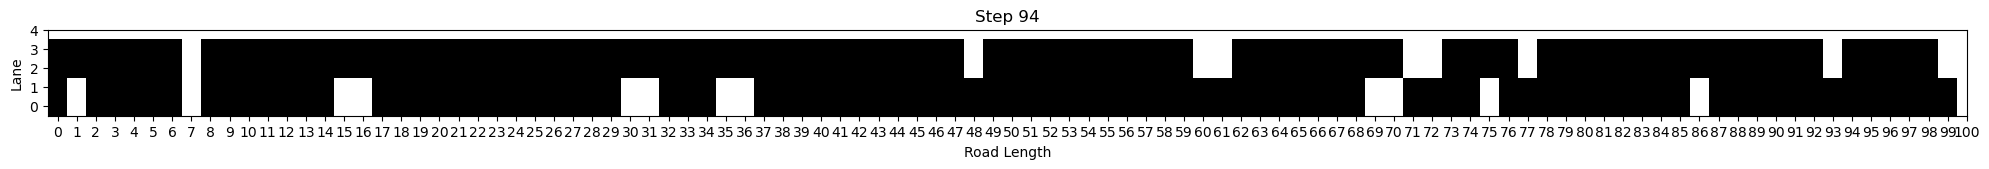

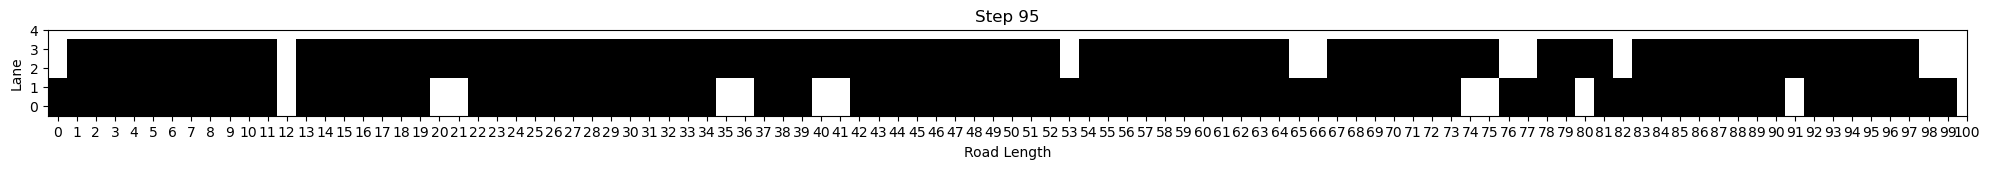

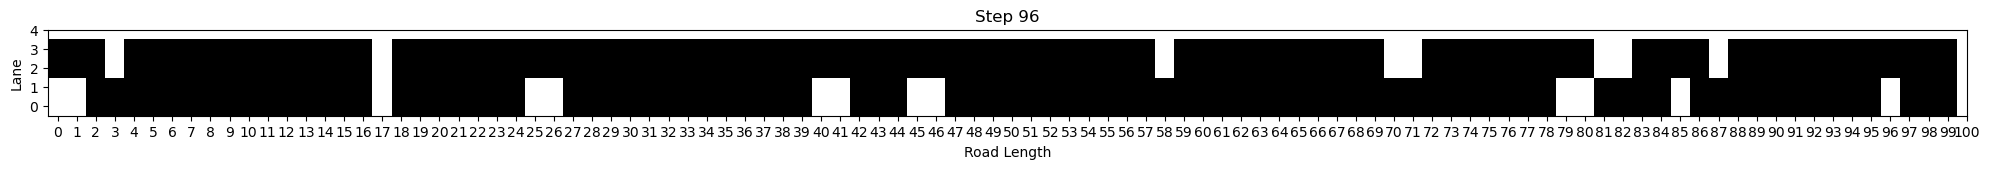

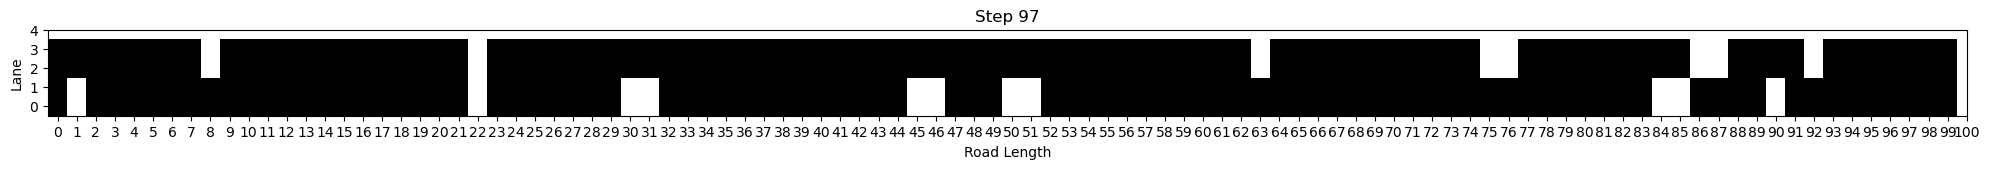

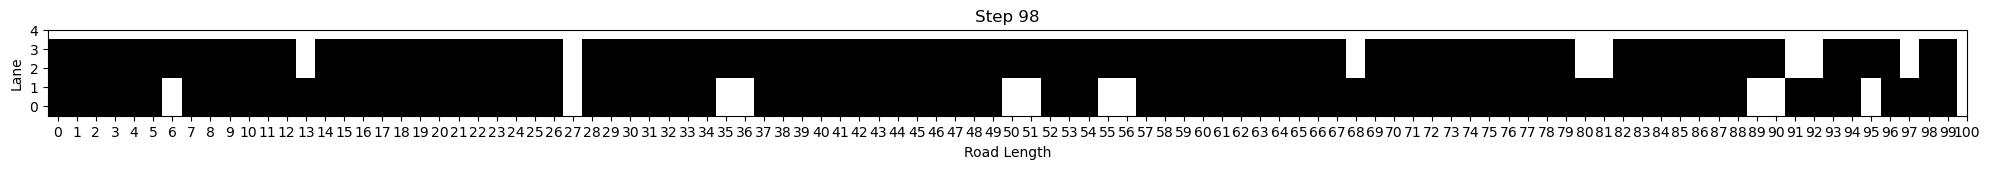

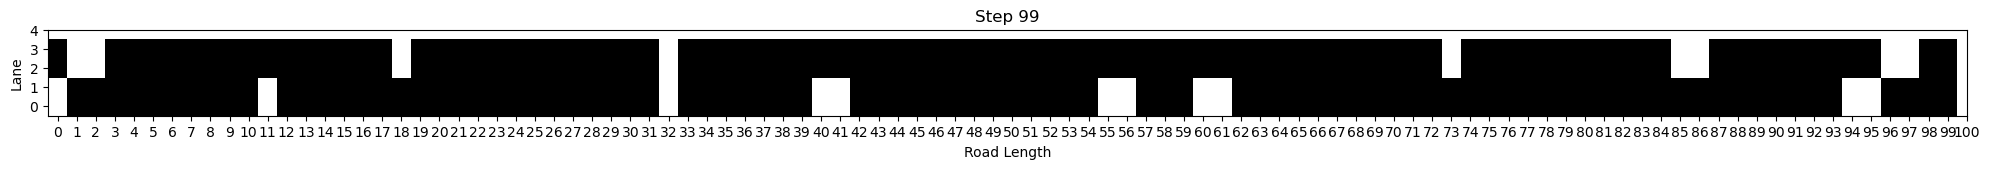

In [73]:
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 0.5  # Example density
truck_fraction = 0.1  # Example truck fraction

for step in range(100):
    simulator.simulation_step(density, truck_fraction)
    if step % 1 == 0:
        simulator.visualize(step)

In [7]:
import numpy as np
np.arange(4)

array([0, 1, 2, 3])

In [19]:
v = range(9,22,2)
print(v)

range(9, 22, 2)


In [15]:
np.linspace(0,10,1)

array([0.])

In [22]:
for i in range(0,30,5):
    print(i)

0
5
10
15
20
25
